# Lockdown  for Classification: Hepatocellular Carcinoma

## Import all necessary libraries

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import plot_tree

from sklearn.metrics import r2_score, classification_report, confusion_matrix,           \
                            roc_curve, roc_auc_score, plot_confusion_matrix, f1_score,   \
                            balanced_accuracy_score, accuracy_score, mean_squared_error, \
                            log_loss
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier,    \
                                 Lasso, lasso_path
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

import scipy
from scipy import stats

import os
import sys
import shutil
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import itertools

import time
import tqdm
import copy

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

import PIL
import joblib
import json

# import mysgd

## Datasets and DataLoaders

In [2]:
# Load data
def load_data(fname):
    """
    input (str or path): name of the folder with the data.
    This function reads the data, transforms it to tensors, and makes it
    global.
    """
    global xtrain, xvalid, xtest, xtrain_valid, ytrain, yvalid, ytest, ytrain_valid
# 
    df = pd.read_csv(os.path.join(fname, 'xtrain.csv'), index_col=False, header=None)
    xtrain = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xvalid.csv'), index_col=False, header=None)
    xvalid = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xtest.csv'), index_col=False, header=None)
    xtest = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xtrain_valid.csv'), index_col=False, header=None)
    xtrain_valid = torch.tensor(df.values).float()
# 
    df = pd.read_csv(os.path.join(fname, 'ytrain.csv'), index_col=False, header=None)
    ytrain = torch.tensor(df.values).long()
    df = pd.read_csv(os.path.join(fname, 'yvalid.csv'), index_col=False, header=None)
    yvalid = torch.tensor(df.values).long()
    df = pd.read_csv(os.path.join(fname, 'ytest.csv'), index_col=False, header=None)
    ytest = torch.tensor(df.values).long()
    df = pd.read_csv(os.path.join(fname, 'ytrain_valid.csv'), index_col=False, header=None)
    ytrain_valid = torch.tensor(df.values).long()

In [3]:
# Transform DataFrame to Tensor
def df_to_tensor():
    """
    This function transforms DataFrames to tensors and makes them global.
    """
    global xtrain, xvalid, xtest, ytrain, yvalid, ytest
# 
    xtrain = torch.tensor(xtrain.values).float()
    xvalid = torch.tensor(xvalid.values).float()
    xtest = torch.tensor(xtest.values).float()
# 
    ytrain = torch.tensor(ytrain.values).long()
    yvalid = torch.tensor(yvalid.values).long()
    ytest = torch.tensor(ytest.values).long()

* ### Read and Clean Data

In [4]:
# Read X and y
X = pd.read_csv('dataset_13LungCancer/GSE137140_gene_profile.csv', index_col=0)
dfy = pd.read_csv('dataset_13LungCancer/GSE137140_output.csv', index_col=1)

In [5]:
# Clean missing values and output classes
X.dropna(axis=1, how='any', inplace=True)

indx = dfy.index[dfy['disease state:ch1'] == 'Lung cancer, post-operation']
X.drop(axis='index', index=indx, inplace=True)
dfy.drop(axis='index', index=indx, inplace=True)

X.columns = X.columns.str.lower()
cols_all = X.columns
dfy.rename(columns={'disease state:ch1': 'disease_state'}, inplace=True)

# Set target
dfy.replace({'disease_state': {"Lung cancer, pre-operation": 1, "Non-cancer control": 0}}, inplace=True)
y = pd.DataFrame(dfy['disease_state'])

In [6]:
# Display data set info
n_features = X.shape[1]
print("- Number of features: {}\n".format(n_features))

print("- Dataset shape: {}\n".format(X.shape))

print("- Missing (X) values: {} points.".format(X.isna().sum().sum()))
print("- Missing (y) values: {} points.\n".format(y.isna().sum().sum()))

print("- Class probabilities:")
print("  label = 1: {}%".format(100*(y.iloc[:,0] == 1).sum()/len(y)))
print("  label = 0: {}%\n".format(100*(y.iloc[:,0] == 0).sum()/len(y)))

- Number of features: 228

- Dataset shape: (3744, 228)

- Missing (X) values: 0 points.
- Missing (y) values: 0 points.

- Class probabilities:
  label = 1: 41.82692307692308%
  label = 0: 58.17307692307692%



* ### Split and Save

In [7]:
# # Random seeds for the splits
# seed1 = torch.randint(0, 1000, (500,))
# seed2 = torch.randint(1001, 2000, (500,))
seed1 = pd.read_csv('seed1.csv', header=None).iloc[:,0].tolist()
seed2 = pd.read_csv('seed2.csv', header=None).iloc[:,0].tolist()

In [8]:
# Split data (function)
def split_data(dfX, dfy, seed1=0, seed2=42):
    global xtrain, xvalid, xtest, xtrain_valid, ytrain, yvalid, ytest, ytrain_valid
    xtrain_valid, xtest, ytrain_valid, ytest = train_test_split(dfX, dfy, 
                                                      test_size=0.2, 
                                                      random_state=seed1)
    xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain_valid, ytrain_valid, 
                                                      test_size=0.25, 
                                                      random_state=seed2)

In [10]:
# Set (xtrain, ytrain), (xvalid, yvalid), and (xtest, ytest)
data_folder = 'dataset_13LungCancer'
split_data(X, y)

# Save data on disk
xtrain.to_csv(os.path.join(data_folder, 'xtrain.csv'), index=False, header=False)
xvalid.to_csv(os.path.join(data_folder, 'xvalid.csv'), index=False, header=False)
xtest.to_csv(os.path.join(data_folder, 'xtest.csv'), index=False, header=False)
xtrain_valid.to_csv(os.path.join(data_folder, 'xtrain_valid.csv'), index=False, header=False)
X.to_csv(os.path.join(data_folder, 'X.csv'), index=False, header=False)

ytrain.to_csv(os.path.join(data_folder, 'ytrain.csv'), index=False, header=False)
yvalid.to_csv(os.path.join(data_folder, 'yvalid.csv'), index=False, header=False)
ytest.to_csv(os.path.join(data_folder, 'ytest.csv'), index=False, header=False)
ytrain_valid.to_csv(os.path.join(data_folder, 'ytrain_valid.csv'), index=False, header=False)
y.to_csv(os.path.join(data_folder, 'y.csv'), index=False, header=False)

# 
print("- xtrain size: {}".format(xtrain.shape))
print("- xvalid size: {}".format(xvalid.shape))
print("- xtest size: {}".format(xtest.shape))
print("- xtrain_valid size: {}\n".format(xtrain_valid.shape))

- xtrain size: (2246, 228)
- xvalid size: (749, 228)
- xtest size: (749, 228)
- xtrain_valid size: (2995, 228)



* ### Create Datasets and DataLoaders

In [11]:
# Create Dataset class
class MyDataset(Dataset):
    '''
    Input:
        xtensor (torch tensor): data points; dimension [# of points, # of features]
        ytensor (torch tensor): y values; dimension [# of points]
    Output:
        the usual...
    '''
    def __init__(self, xtensor, ytensor):
        self.x = xtensor
        self.y = ytensor
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx], idx

In [12]:
# Instantiate DataLoaders
def make_DataLoaders(batch_size=100000, num_workers = 0):
    """
    This function instantiate and makes global DataLoaders for training, 
    validation, and testing datasets. 
    """
# .create datasets
    train_dataset = MyDataset(xtrain, ytrain)
    valid_dataset = MyDataset(xvalid, yvalid)
    test_dataset = MyDataset(xtest, ytest)
    
# .make dataloaders global variables
    global train_dataloader, valid_dataloader, test_dataloader
    train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = True, 
                                                   num_workers=num_workers)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = True, 
                                                   num_workers=num_workers)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = False, 
                                                   num_workers=num_workers)
    print('- train minibatches =', len(train_dataloader))
    print('- valid minibatches =', len(valid_dataloader))
    print('- test minibatches =', len(test_dataloader))

In [13]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
    !nvidia-smi
else:
    print("-Type of precessor to be used: 'cpu'")
    
# Choose device
# torch.cuda.set_device(6)

-Type of precessor to be used: 'cpu'


## Optimizer and Loss Function

In [14]:
# Set up SGD optimizer with a constant learning rate
def setup_SGD(model, lr):
    """
    Args:
        model (nn.Module class): model previously instantiated
        lr (float): learning rate
    Returns:
        instantiated optimizer
    """
    return optim.SGD(model.parameters(), lr=lr, momentum=0,  weight_decay=0.0)

In [15]:
# Set up Adam optimizer with a constant learning rate
def setup_ADAM(model, lr):
    """
    Args:
        model (nn.Module class): model previously instantiated
        lr (float): learning rate
    Returns:
        instantiated optimizer
    """
    return optim.Adam(model.parameters(), lr=lr,  weight_decay=0.0)

In [16]:
# Type of Loss Function
loss_type = nn.CrossEntropyLoss(reduction='mean')

## Train model

In [17]:
# PyTorch sign function
def sgn(x):
    return torch.sign(x)

In [18]:
# Number of correct predictions in a multi-class classification problem
def accuracy_multiclass(output, target):
    """
    Args:
        output (torch tensor): 2D tensor of shape (batch_size, n_classes) resulting 
                               of running the model.
        target (torch tensor): 1D tensor with the corresponding class for each image.
    Returns:
        correct (int): number of correct predictions.
    """
    correct = 0
    prob_softmax = nn.Softmax(dim=1)
    _, predictions = torch.max(prob_softmax(output), dim=1)
    correct = (predictions == target).sum(dim=0)
    return correct

In [19]:
# Compute accuracy
def dataset_accuracy(data_loader, model, device):
    """
    Args:
        data_loader: torch DataLoader.
        model:       torch model previously trained.
        device: 'gpu' or 'cpu'.
    Returns:
        Accuracy for the given data set.
    """
# Initialize some local variables
    correct_total = 0
    n_points = 0
    
# Put model in evaluation mode
    model.eval()

# Loop over mini batches (no gradients need to be computed)
    with torch.no_grad():
        for i, (xx, yy, _) in enumerate(data_loader, start=1):
            batch_size = len(yy)
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)
        
# .compute accuracy (target size must be [batch_size])
            correct = accuracy_multiclass(yy_pred, yy.view(-1))
            correct_total += correct
        
# .number of points used after the ith mini-batch
            n_points += batch_size
#
    return correct_total.item()/n_points

In [97]:
# Train model (classification)
def train_model(lr, features, layer_sizes, lock_flag=False, epochs=3000, 
                early_stop=300, fname='model'):
    """
    """
# Set seed of random generators (for reproducibility purposes)
    torch.manual_seed(42)

# Instantiate Model and Optimizer
    model = MyNet(features, layer_sizes)
    if lock_flag == True:
        model.load_state_dict(torch.load(model_forward_name))
    model = model.to(device)
    optimizer = setup_SGD(model, lr)

# LOCKDOWN SECTION 1:
    if lock_flag == True:
        n_iterations = epochs*len(train_dataloader)
        layers = get_lockdown_layers(model)
        t0 = []
        t0_initial = []
        sign_w0 = []
        l = 0
        for layer in layers:
            ww = layer.weight.detach()
            t0.append(abs(ww).sum())
            sign_w0.append(torch.sign(ww))
            t0_initial.append(t0[l])
            l += 1
    
# DataFrames to store train/valid loss function
    train_loss = pd.DataFrame(columns=['iteration', 'loss'])
    valid_loss = pd.DataFrame(columns=['iteration', 'loss'])

# Initialize some local variables...
    iteration = 0
    best_iter = 0
    best_loss = 1e30
    stop_flag = 0

# Loop Over Number of Epochs
    iterator = tqdm.notebook.tqdm(range(1, epochs + 1), desc='Epochs loop')
    for n_epoch in iterator:
# 
# .Loop Over Mini-batches
        for ibatch, (xx, yy, _) in enumerate(train_dataloader, start=1):
#
# ..Compute Validation Loss
            model_dict = copy.deepcopy(model.state_dict())
            epoch_loss = valid_epoch(valid_dataloader, model, loss_type, device)
            valid_loss = valid_loss.append({'iteration': iteration + 1, 
                                            'loss': epoch_loss}, 
                                            ignore_index=True)
# ..Train Mini-batch:
            model.train()
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)

# ..Compute Train Loss
            loss = loss_type(yy_pred, yy.view(-1))
            train_loss = train_loss.append({'iteration': iteration + 1,
                                            'loss': loss.item()}, 
                                           ignore_index=True)
# ..Backward Propagation
            optimizer.zero_grad()
            loss.backward()

# ..LOCKDOWN SECTION 2:
            if lock_flag == True:
                l = 0
                for layer in layers:
# ...weights and gradients (2D)
                    w2d = layer.weight.detach()
                    g2d = layer.weight.grad.detach()
                    w_shape = g2d.size()

# ...flattens weights and compute P(W)
                    w1d = torch.flatten(w2d)
                    Pw = abs(w1d).sum()

# ...find g=-grads, 'gamma', and sort gamma (in descending order)
                    p1d = 1.0
                    g1d = -torch.flatten(g2d)
                    gamma = abs(g1d)/(p1d + 1e-10)
                    _, indx1d = torch.sort(gamma, descending=True)

# ...Modify Gradients Accordingly:
                    grmin = torch.zeros(w_shape).fill_(1e-1).to(device)
                    layer.weight.grad = torch.sign(g2d)*torch.max(abs(g2d), grmin)
                    gr1d = torch.flatten(layer.weight.grad.detach())
                    pjsj = lr*abs(gr1d[indx1d])

# ...sign(g) != sign(w) elements
                    mask_ds = (sgn(g1d[indx1d]) != sgn(w1d[indx1d])) & (w1d[indx1d] != 0.0)
                    DS_sum = pjsj[mask_ds].sum()
                    pjsj[mask_ds] = 0.0
                    mask_dsc = ~mask_ds
                    indx1d_dsc = indx1d[mask_dsc]

# ...sum(pjsj), j={1,J-1}
                    left_side = torch.cumsum(pjsj, dim=0) - pjsj
                    pjsj_dsc = torch.zeros(len(g1d)).to(device)
                    pjsj_dsc[:] = pjsj[:]

# ...sum(pjsj) + Penalty, j={J+1,nJ}
                    mask_w0 = (w1d[indx1d] == 0.0)
                    pjsj_dsc[mask_w0] = 0.0
                    right_side = pjsj_dsc.sum() - torch.cumsum(pjsj_dsc, dim=0) + DS_sum - Pw + t0[l]

# ...delta_j and new steps
                    ds = right_side - left_side
                    mask_w0 = (~mask_w0).float()
                    pjsj_new = -mask_w0**(1-sgn(ds))*sgn(g1d[indx1d])*sgn(ds)*torch.min(pjsj, abs(ds))

# ...modify gradients
                    indx2d = np.unravel_index(indx1d_dsc.cpu(), shape=w_shape)
                    layer.weight.grad[indx2d] = pjsj_new[mask_dsc]/lr
                    l = l + 1

# ..Update Weights 
            optimizer.step()

# ..LOCKDOWN SECTION 3:
            if lock_flag == True:
# ...Set Weights That Change Signs to Zero
                l = 0
                for layer in layers:
                    ww = layer.weight.detach()
                    sign_w = sgn(ww)
                    mask0 = ((sign_w != sign_w0[l]) & (sign_w0[l] != 0.0))
                    with torch.no_grad():
                        layer.weight[mask0] = 0.0
                    sign_w0[l] = sign_w
                    
# ...Tighten Constraint
                    if iteration%step == 0:
                        t0[l] = (1.0 - iteration/n_iterations)*t0_initial[l]
                    l = l + 1
                    

# ..Early Stop
            batch_loss = valid_loss.iloc[iteration, 1]
            if batch_loss < best_loss:
                torch.save(model_dict, fname+"_best.pth")
                best_loss = batch_loss
                best_iter = iteration
            else:
                if iteration - best_iter >= early_stop:
                    stop_flag = 1
                    break
# 
            iteration += 1
# 
        if stop_flag == 1:
            break
# 
    if lock_flag == False:
        torch.save(model_dict, fname+"_last.pth")
    print("Summary:")
    print("-learning rate = {:.5f}".format(lr))
    if stop_flag == 1:
        print('-path 1 has early stopped:')
        print(' {:d} iterations with no improvement in train loss.'.format(early_stop))
    print("-Model saved after iteration {:d}.".format(best_iter + 1))
    print("-Train.  Loss={:.7f}".format(train_loss.iloc[best_iter, 1]))
    print("-Valid.  Loss={:.7f}".format(valid_loss.iloc[best_iter, 1]))
# 
    return train_loss, valid_loss

In [22]:
# Evaluate one epoch (classification)
def valid_epoch(data_loader, model, loss_type, device):
    """
    Args:
        data_loader: torch DataLoader.
        model:       torch model previously trained.
        device: 'gpu' or 'cpu'.
    Returns:
        Values of Loss Function after one epoch.
    """
# Initialize some local variables
    loss_fun = 0.
    n_points = 0
    
# Put model in evaluation mode
    model.eval()

# Loop over mini batches (no gradients need to be computed)
    with torch.no_grad():
        for i, (xx, yy, _) in enumerate(data_loader, start=1):
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)
        
# .compute loss function
            batch_size = len(yy)
            loss = loss_type(yy_pred, yy.view(-1))
            loss_fun += batch_size*loss.item()
        
# .number of points used after the ith mini-batch
            n_points += batch_size
#
    return loss_fun/n_points

## Results:

* ### Lasso

In [9]:
# Load data
load_data('dataset_13LungCancer')

# transform tensors to NumPy arrays
xtrain = xtrain.numpy()
xvalid = xvalid.numpy()
xtest = xtest.numpy()

ytrain = ytrain.numpy()
yvalid = yvalid.numpy()
ytest = ytest.numpy()

In [10]:
# Normalize data sets
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xvalid = scaler.transform(xvalid)
xtest  = scaler.transform(xtest)

In [11]:
# Grid search space
grid_C = np.geomspace(1e-2, 1e3, num=1000)
df_grid_loss = pd.DataFrame(columns = ['C', 'valid_loss', 'valid_accu'], 
                            index=range(len(grid_C)))

params = {'penalty': 'l1', 
          'solver': 'liblinear',
          'max_iter': 10000,
          'random_state': 42,
          'warm_start': True}

In [12]:
# Perform grid search
data_out = 'data_lasso_13LungCancer'
iterator = tqdm.notebook.tqdm(range(1, len(grid_C) + 1), desc='C-grid loop')
for n in iterator:
    irow = n-1
    params['C'] = grid_C[irow]
    log_clf = LogisticRegression(**params).fit(xtrain, ytrain.ravel())
    
    ypred = log_clf.predict_proba(xvalid)
    val_loss = log_loss(yvalid, ypred)
    val_accu = log_clf.score(xvalid, yvalid.ravel())
    
    df_grid_loss.iloc[irow,:] = [params['C'], val_loss, val_accu]
    print("C={:.5f} | valid_logloss={:.5f},  valid_accu={:.5f}".format(params['C'], 
                                                                       val_loss, 
                                                                       val_accu))
    
df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_loss.csv'), index=None)

C-grid loop:   0%|          | 0/1000 [00:00<?, ?it/s]

C=0.01000 | valid_logloss=0.16766,  valid_accu=0.96262
C=0.01012 | valid_logloss=0.16674,  valid_accu=0.96262
C=0.01023 | valid_logloss=0.16568,  valid_accu=0.96262
C=0.01035 | valid_logloss=0.16489,  valid_accu=0.96395
C=0.01047 | valid_logloss=0.16374,  valid_accu=0.96395
C=0.01059 | valid_logloss=0.16289,  valid_accu=0.96529
C=0.01072 | valid_logloss=0.16186,  valid_accu=0.96529
C=0.01084 | valid_logloss=0.16076,  valid_accu=0.96529
C=0.01097 | valid_logloss=0.16000,  valid_accu=0.96395
C=0.01109 | valid_logloss=0.15906,  valid_accu=0.96395
C=0.01122 | valid_logloss=0.15795,  valid_accu=0.96395
C=0.01135 | valid_logloss=0.15738,  valid_accu=0.96395
C=0.01148 | valid_logloss=0.15655,  valid_accu=0.96395
C=0.01162 | valid_logloss=0.15560,  valid_accu=0.96395
C=0.01175 | valid_logloss=0.15464,  valid_accu=0.96395
C=0.01189 | valid_logloss=0.15374,  valid_accu=0.96395
C=0.01202 | valid_logloss=0.15278,  valid_accu=0.96395
C=0.01216 | valid_logloss=0.15199,  valid_accu=0.96395
C=0.01231 

C=0.05569 | valid_logloss=0.07326,  valid_accu=0.97196
C=0.05633 | valid_logloss=0.07265,  valid_accu=0.97196
C=0.05698 | valid_logloss=0.07234,  valid_accu=0.97196
C=0.05764 | valid_logloss=0.07212,  valid_accu=0.97196
C=0.05831 | valid_logloss=0.07176,  valid_accu=0.97196
C=0.05899 | valid_logloss=0.07152,  valid_accu=0.97196
C=0.05967 | valid_logloss=0.07126,  valid_accu=0.97196
C=0.06036 | valid_logloss=0.07096,  valid_accu=0.97196
C=0.06106 | valid_logloss=0.07060,  valid_accu=0.97196
C=0.06177 | valid_logloss=0.07027,  valid_accu=0.97330
C=0.06249 | valid_logloss=0.07012,  valid_accu=0.97196
C=0.06321 | valid_logloss=0.06970,  valid_accu=0.97330
C=0.06394 | valid_logloss=0.06950,  valid_accu=0.97330
C=0.06469 | valid_logloss=0.06917,  valid_accu=0.97330
C=0.06544 | valid_logloss=0.06884,  valid_accu=0.97330
C=0.06619 | valid_logloss=0.06881,  valid_accu=0.97330
C=0.06696 | valid_logloss=0.06845,  valid_accu=0.97330
C=0.06774 | valid_logloss=0.06833,  valid_accu=0.97330
C=0.06852 

C=0.31009 | valid_logloss=0.04790,  valid_accu=0.98264
C=0.31369 | valid_logloss=0.04789,  valid_accu=0.98264
C=0.31732 | valid_logloss=0.04785,  valid_accu=0.98398
C=0.32100 | valid_logloss=0.04764,  valid_accu=0.98398
C=0.32472 | valid_logloss=0.04768,  valid_accu=0.98398
C=0.32849 | valid_logloss=0.04761,  valid_accu=0.98398
C=0.33229 | valid_logloss=0.04762,  valid_accu=0.98264
C=0.33614 | valid_logloss=0.04756,  valid_accu=0.98398
C=0.34004 | valid_logloss=0.04740,  valid_accu=0.98398
C=0.34398 | valid_logloss=0.04746,  valid_accu=0.98398
C=0.34797 | valid_logloss=0.04738,  valid_accu=0.98398
C=0.35200 | valid_logloss=0.04741,  valid_accu=0.98398
C=0.35608 | valid_logloss=0.04743,  valid_accu=0.98398
C=0.36021 | valid_logloss=0.04729,  valid_accu=0.98531
C=0.36439 | valid_logloss=0.04725,  valid_accu=0.98264
C=0.36861 | valid_logloss=0.04731,  valid_accu=0.98264
C=0.37288 | valid_logloss=0.04729,  valid_accu=0.98264
C=0.37720 | valid_logloss=0.04713,  valid_accu=0.98398
C=0.38158 

C=1.76704 | valid_logloss=0.05628,  valid_accu=0.98131
C=1.78753 | valid_logloss=0.05643,  valid_accu=0.98131
C=1.80824 | valid_logloss=0.05601,  valid_accu=0.98131
C=1.82920 | valid_logloss=0.05594,  valid_accu=0.98131
C=1.85041 | valid_logloss=0.05683,  valid_accu=0.98131
C=1.87186 | valid_logloss=0.05683,  valid_accu=0.98131
C=1.89355 | valid_logloss=0.05675,  valid_accu=0.98131
C=1.91550 | valid_logloss=0.05710,  valid_accu=0.98131
C=1.93770 | valid_logloss=0.05736,  valid_accu=0.98131
C=1.96016 | valid_logloss=0.05742,  valid_accu=0.98131
C=1.98288 | valid_logloss=0.05741,  valid_accu=0.98264
C=2.00587 | valid_logloss=0.05760,  valid_accu=0.98131
C=2.02912 | valid_logloss=0.05753,  valid_accu=0.98264
C=2.05264 | valid_logloss=0.05780,  valid_accu=0.98264
C=2.07643 | valid_logloss=0.05788,  valid_accu=0.98131
C=2.10050 | valid_logloss=0.05793,  valid_accu=0.98264
C=2.12485 | valid_logloss=0.05778,  valid_accu=0.98264
C=2.14947 | valid_logloss=0.05782,  valid_accu=0.98264
C=2.17439 

C=10.06939 | valid_logloss=0.07535,  valid_accu=0.97997
C=10.18610 | valid_logloss=0.07590,  valid_accu=0.97864
C=10.30417 | valid_logloss=0.07727,  valid_accu=0.97864
C=10.42361 | valid_logloss=0.07603,  valid_accu=0.97864
C=10.54443 | valid_logloss=0.07674,  valid_accu=0.97864
C=10.66665 | valid_logloss=0.07692,  valid_accu=0.97864
C=10.79029 | valid_logloss=0.07636,  valid_accu=0.97864
C=10.91536 | valid_logloss=0.07705,  valid_accu=0.97864
C=11.04188 | valid_logloss=0.07692,  valid_accu=0.97730
C=11.16987 | valid_logloss=0.07787,  valid_accu=0.97864
C=11.29934 | valid_logloss=0.07752,  valid_accu=0.97730
C=11.43031 | valid_logloss=0.07727,  valid_accu=0.97864
C=11.56280 | valid_logloss=0.07793,  valid_accu=0.97730
C=11.69683 | valid_logloss=0.07828,  valid_accu=0.97864
C=11.83241 | valid_logloss=0.07907,  valid_accu=0.98131
C=11.96956 | valid_logloss=0.07964,  valid_accu=0.97997
C=12.10830 | valid_logloss=0.08078,  valid_accu=0.97997
C=12.24865 | valid_logloss=0.08006,  valid_accu=

C=55.42986 | valid_logloss=0.10027,  valid_accu=0.97597
C=56.07235 | valid_logloss=0.10039,  valid_accu=0.97597
C=56.72229 | valid_logloss=0.10527,  valid_accu=0.97730
C=57.37976 | valid_logloss=0.10610,  valid_accu=0.97730
C=58.04486 | valid_logloss=0.10161,  valid_accu=0.97597
C=58.71766 | valid_logloss=0.10022,  valid_accu=0.97597
C=59.39827 | valid_logloss=0.10036,  valid_accu=0.97597
C=60.08676 | valid_logloss=0.10049,  valid_accu=0.97597
C=60.78323 | valid_logloss=0.10080,  valid_accu=0.97597
C=61.48778 | valid_logloss=0.10094,  valid_accu=0.97597
C=62.20049 | valid_logloss=0.10108,  valid_accu=0.97597
C=62.92146 | valid_logloss=0.10122,  valid_accu=0.97597
C=63.65079 | valid_logloss=0.10136,  valid_accu=0.97597
C=64.38857 | valid_logloss=0.10150,  valid_accu=0.97597
C=65.13491 | valid_logloss=0.10164,  valid_accu=0.97597
C=65.88990 | valid_logloss=0.10178,  valid_accu=0.97597
C=66.65363 | valid_logloss=0.10192,  valid_accu=0.97597
C=67.42622 | valid_logloss=0.10261,  valid_accu=

C=301.63343 | valid_logloss=0.11177,  valid_accu=0.97330
C=305.12970 | valid_logloss=0.11181,  valid_accu=0.97330
C=308.66649 | valid_logloss=0.11184,  valid_accu=0.97330
C=312.24428 | valid_logloss=0.11188,  valid_accu=0.97330
C=315.86354 | valid_logloss=0.11192,  valid_accu=0.97330
C=319.52475 | valid_logloss=0.11195,  valid_accu=0.97330
C=323.22840 | valid_logloss=0.11199,  valid_accu=0.97330
C=326.97497 | valid_logloss=0.11203,  valid_accu=0.97330
C=330.76498 | valid_logloss=0.11206,  valid_accu=0.97330
C=334.59891 | valid_logloss=0.11210,  valid_accu=0.97330
C=338.47729 | valid_logloss=0.11213,  valid_accu=0.97330
C=342.40061 | valid_logloss=0.11216,  valid_accu=0.97330
C=346.36942 | valid_logloss=0.11220,  valid_accu=0.97330
C=350.38422 | valid_logloss=0.11223,  valid_accu=0.97330
C=354.44557 | valid_logloss=0.11226,  valid_accu=0.97330
C=358.55399 | valid_logloss=0.11230,  valid_accu=0.97330
C=362.71003 | valid_logloss=0.11233,  valid_accu=0.97330
C=366.91424 | valid_logloss=0.1

In [13]:
# Display grid search results
data_out = 'data_lasso_13LungCancer'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss.csv'))

idx = df_grid_loss.valid_loss.idxmin()
best_C   = df_grid_loss.iloc[idx, 0]
best_loss  = df_grid_loss.iloc[idx, 1]
print("Best parameters ({}):".format(idx))
print("- Best C = {:.5f}".format(best_C))
print("- Best valid loss = {:.5f}".format(best_loss))

Best parameters (323):
- Best C = 0.41363
- Best valid loss = 0.04708


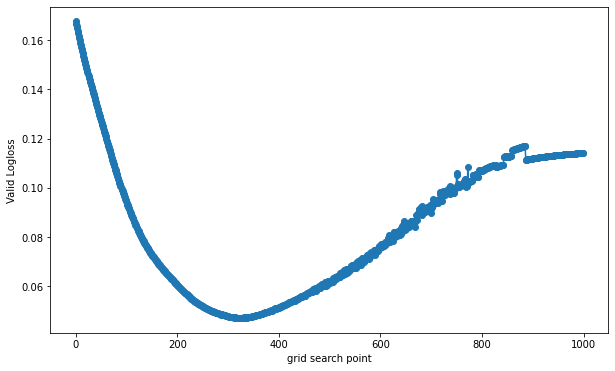

In [14]:
# Plot Loss vs point in grid search
data_out = 'data_lasso_13LungCancer'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.plot(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.set_xlabel("grid search point")
axes.set_ylabel("Valid Logloss")
plt.show()

In [15]:
# Train with best hyperparameters
params['C'] = best_C
log_clf = LogisticRegression(**params).fit(xtrain, ytrain.ravel())

In [16]:
# Save model and model's best params
data_out = 'data_lasso_13LungCancer'
joblib.dump(log_clf, os.path.join(data_out, 'lasso_model_val.pkl'))
print("model saved at: '{}'".format(os.path.join(data_out, 'lasso_model_val.pkl')))

best_params = {}
best_params['C'] = best_C
with open(os.path.join(data_out, 'lasso_best_params.json'), 'w') as f:
    json.dump(best_params, f)
print("best params saved at: '{}'".format(os.path.join(data_out, 'lasso_best_params.json')))

model saved at: 'data_lasso_13LungCancer/lasso_model_val.pkl'
best params saved at: 'data_lasso_13LungCancer/lasso_best_params.json'


In [17]:
# Find MSE, R2, Accuracy, etc...
data_out = 'data_lasso_13LungCancer'
model = joblib.load(os.path.join(data_out, 'lasso_model_val.pkl'))

df_results = pd.DataFrame(index=['train', 'valid', 'test'], 
                           columns=['accuracy', 'roc_auc'])

ypred = model.predict(xtrain)
df_results.loc['train', 'accuracy'] = accuracy_score(ytrain, ypred)
df_results.loc['train', 'roc_auc']  = roc_auc_score(ytrain, ypred)

ypred = model.predict(xvalid)
df_results.loc['valid', 'accuracy'] = accuracy_score(yvalid, ypred)
df_results.loc['valid', 'roc_auc']  = roc_auc_score(yvalid, ypred)

ypred = model.predict(xtest)
df_results.loc['test', 'accuracy'] = accuracy_score(ytest, ypred)
df_results.loc['test', 'roc_auc']  = roc_auc_score(ytest, ypred)

# Save data
df_results.to_csv(os.path.join(data_out, 'results_target_val.csv'), index=True)
print("model results saved at: '{}'".format(os.path.join(data_out, 'results_target_val.csv')))
df_results.head()

model results saved at: 'data_lasso_13LungCancer/results_target_val.csv'


,accuracy,roc_auc
train,0.995102,0.994862
valid,0.981308,0.981341
test,0.971963,0.973613


In [125]:
# Find Accuracy +/- STD
data_in  = 'data_lasso_13LungCancer'
data_out = 'data_lasso_13LungCancer/partitions'
df_results = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 'train_roc', 'valid_roc', 'test_roc'])

model = joblib.load(os.path.join(data_in, 'lasso_model_val.pkl'))

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])
    
# .normalize data sets
    scaler = StandardScaler()
    scaler.fit(xtrain)
    xtrain = scaler.transform(xtrain)
    xvalid = scaler.transform(xvalid)
    xtest  = scaler.transform(xtest)
    
# .train model
    ytrain = ytrain.values.ravel()
    yvalid = yvalid.values.ravel()
    ytest  = ytest.values.ravel()
    model.fit(xtrain, ytrain)
    
# .compute/save accuracy
    ypred = model.predict(xtrain)
    df_results.loc[n, 'train_acc'] = accuracy_score(ytrain, ypred)
    df_results.loc[n, 'train_roc']  = roc_auc_score(ytrain, ypred)

    ypred = model.predict(xvalid)
    df_results.loc[n, 'valid_acc'] = accuracy_score(yvalid, ypred)
    df_results.loc[n, 'valid_roc']  = roc_auc_score(yvalid, ypred)

    ypred = model.predict(xtest)
    df_results.loc[n, 'test_acc'] = accuracy_score(ytest, ypred)
    df_results.loc[n, 'test_roc']  = roc_auc_score(ytest, ypred)

    joblib.dump(model, os.path.join(data_out, 'lasso_model_val_'+str(n)+'.pkl'))
    df_results.to_csv(os.path.join(data_out, 'accuracy_lasso_val.csv'), index=True)

Partitions loop:   0%|          | 0/100 [00:00<?, ?it/s]

In [127]:
# Display results
data_out = 'data_lasso_13LungCancer'
accuracy_lasso = pd.read_csv(os.path.join(data_out, 'accuracy13_lasso_val.csv'))
print("Train accuracy = {:.3f} +/- {:.3f}".format(accuracy_lasso['train_acc'].mean(), 
                                                  accuracy_lasso['train_acc'].std()))
print("Valid accuracy = {:.3f} +/- {:.3f}".format(accuracy_lasso['valid_acc'].mean(), 
                                                  accuracy_lasso['valid_acc'].std()))
print("Test accuracy = {:.3f} +/- {:.3f}".format(accuracy_lasso['test_acc'].mean(), 
                                                 accuracy_lasso['test_acc'].std()))

Train accuracy = 0.994 +/- 0.001
Valid accuracy = 0.979 +/- 0.005
Test accuracy = 0.980 +/- 0.005


* ### Gradient Boosting

In [128]:
# Load data
load_data('dataset_13LungCancer')

# transform tensors to NumPy arrays
xtrain = xtrain.numpy()
xvalid = xvalid.numpy()
xtest = xtest.numpy()

ytrain = ytrain.numpy()
yvalid = yvalid.numpy()
ytest = ytest.numpy()

In [129]:
# Normalize data sets
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xvalid = scaler.transform(xvalid)
xtest  = scaler.transform(xtest)

In [196]:
# Build DMatrices
dtrain = xgb.DMatrix(data=xtrain, label=ytrain, nthread=10, feature_names=cols_all)
dvalid = xgb.DMatrix(data=xvalid, label=yvalid, nthread=10, feature_names=cols_all)
dtest  = xgb.DMatrix(data=xtest,  label=ytest,  nthread=10, feature_names=cols_all)

valid_list = [(dtrain, 'train'), (dvalid, 'valid')]

In [134]:
# Grid search space
grid_eta   = np.geomspace(0.01, 0.99, num=100)
grid_depth = [1, 2, 3, 4, 5, 6, 7]
grid_param = [(eta, max_depth) for eta in grid_eta
                               for max_depth in grid_depth]

param = [('eta', 0.01), 
         ('max_depth', 2), 
         ('objective', 'binary:logistic'), 
         ('nthread', 16),
         ('eval_metric', 'logloss')
]

In [136]:
# Perform grid search
df_grid_loss = pd.DataFrame(columns = ['eta', 'max_depth', 'valid_loss'], 
                            index = range(len(grid_param)))
i = 0
for eta, max_depth in grid_param:
    param[0] = ('eta', eta)
    param[1] = ('max_depth', max_depth)
    
    xgb_clf = xgb.train(param, dtrain, 
                        num_boost_round = 10000, 
                        evals = valid_list, 
                        early_stopping_rounds = 30, 
                        verbose_eval = False)
    
    print("eta={}, max_depth={} | valid_logloss={:.5f} (iters={})".format(eta, 
                                                                          max_depth, 
                                                                          xgb_clf.best_score, 
                                                                          xgb_clf.best_iteration))
    df_grid_loss.iloc[i,:] = [eta, max_depth, xgb_clf.best_score]
    i += 1
    
# Save grid search results
    data_out = 'data_xgb_13LungCancer'
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_loss.csv'), index=None)

eta=0.01, max_depth=1 | valid_logloss=0.04955 (iters=5131)
eta=0.01, max_depth=2 | valid_logloss=0.04320 (iters=2525)
eta=0.01, max_depth=3 | valid_logloss=0.05004 (iters=1351)
eta=0.01, max_depth=4 | valid_logloss=0.04849 (iters=1632)
eta=0.01, max_depth=5 | valid_logloss=0.05013 (iters=1602)
eta=0.01, max_depth=6 | valid_logloss=0.04947 (iters=1445)
eta=0.01, max_depth=7 | valid_logloss=0.04866 (iters=2068)
eta=0.010475094057619858, max_depth=1 | valid_logloss=0.04845 (iters=5463)
eta=0.010475094057619858, max_depth=2 | valid_logloss=0.04352 (iters=2517)
eta=0.010475094057619858, max_depth=3 | valid_logloss=0.04825 (iters=1753)
eta=0.010475094057619858, max_depth=4 | valid_logloss=0.04856 (iters=1470)
eta=0.010475094057619858, max_depth=5 | valid_logloss=0.05104 (iters=1335)
eta=0.010475094057619858, max_depth=6 | valid_logloss=0.04953 (iters=1477)
eta=0.010475094057619858, max_depth=7 | valid_logloss=0.04944 (iters=1693)
eta=0.010972759551598283, max_depth=1 | valid_logloss=0.04863 

eta=0.021014879308720747, max_depth=1 | valid_logloss=0.04952 (iters=2431)
eta=0.021014879308720747, max_depth=2 | valid_logloss=0.04317 (iters=1187)
eta=0.021014879308720747, max_depth=3 | valid_logloss=0.04996 (iters=648)
eta=0.021014879308720747, max_depth=4 | valid_logloss=0.04789 (iters=877)
eta=0.021014879308720747, max_depth=5 | valid_logloss=0.05083 (iters=836)
eta=0.021014879308720747, max_depth=6 | valid_logloss=0.04897 (iters=1011)
eta=0.021014879308720747, max_depth=7 | valid_logloss=0.04839 (iters=1023)
eta=0.02201328373683792, max_depth=1 | valid_logloss=0.04943 (iters=2347)
eta=0.02201328373683792, max_depth=2 | valid_logloss=0.04290 (iters=1169)
eta=0.02201328373683792, max_depth=3 | valid_logloss=0.04961 (iters=620)
eta=0.02201328373683792, max_depth=4 | valid_logloss=0.04748 (iters=880)
eta=0.02201328373683792, max_depth=5 | valid_logloss=0.05166 (iters=599)
eta=0.02201328373683792, max_depth=6 | valid_logloss=0.04818 (iters=905)
eta=0.02201328373683792, max_depth=7 |

eta=0.04416251523600994, max_depth=1 | valid_logloss=0.04577 (iters=1692)
eta=0.04416251523600994, max_depth=2 | valid_logloss=0.04341 (iters=649)
eta=0.04416251523600994, max_depth=3 | valid_logloss=0.04964 (iters=463)
eta=0.04416251523600994, max_depth=4 | valid_logloss=0.04743 (iters=419)
eta=0.04416251523600994, max_depth=5 | valid_logloss=0.04915 (iters=487)
eta=0.04416251523600994, max_depth=6 | valid_logloss=0.04903 (iters=475)
eta=0.04416251523600994, max_depth=7 | valid_logloss=0.05129 (iters=491)
eta=0.04626065009182741, max_depth=1 | valid_logloss=0.04663 (iters=1551)
eta=0.04626065009182741, max_depth=2 | valid_logloss=0.04402 (iters=583)
eta=0.04626065009182741, max_depth=3 | valid_logloss=0.04656 (iters=421)
eta=0.04626065009182741, max_depth=4 | valid_logloss=0.04749 (iters=433)
eta=0.04626065009182741, max_depth=5 | valid_logloss=0.05034 (iters=428)
eta=0.04626065009182741, max_depth=6 | valid_logloss=0.05145 (iters=453)
eta=0.04626065009182741, max_depth=7 | valid_logl

eta=0.09280699276542904, max_depth=2 | valid_logloss=0.04196 (iters=349)
eta=0.09280699276542904, max_depth=3 | valid_logloss=0.04933 (iters=204)
eta=0.09280699276542904, max_depth=4 | valid_logloss=0.04513 (iters=219)
eta=0.09280699276542904, max_depth=5 | valid_logloss=0.05040 (iters=132)
eta=0.09280699276542904, max_depth=6 | valid_logloss=0.04759 (iters=219)
eta=0.09280699276542904, max_depth=7 | valid_logloss=0.04979 (iters=180)
eta=0.09721619784227144, max_depth=1 | valid_logloss=0.05446 (iters=301)
eta=0.09721619784227144, max_depth=2 | valid_logloss=0.04091 (iters=304)
eta=0.09721619784227144, max_depth=3 | valid_logloss=0.04694 (iters=202)
eta=0.09721619784227144, max_depth=4 | valid_logloss=0.04899 (iters=194)
eta=0.09721619784227144, max_depth=5 | valid_logloss=0.04959 (iters=225)
eta=0.09721619784227144, max_depth=6 | valid_logloss=0.05099 (iters=189)
eta=0.09721619784227144, max_depth=7 | valid_logloss=0.05203 (iters=222)
eta=0.10183488163219744, max_depth=1 | valid_loglos

eta=0.1950327751970811, max_depth=3 | valid_logloss=0.05102 (iters=97)
eta=0.1950327751970811, max_depth=4 | valid_logloss=0.04907 (iters=210)
eta=0.1950327751970811, max_depth=5 | valid_logloss=0.04500 (iters=112)
eta=0.1950327751970811, max_depth=6 | valid_logloss=0.04930 (iters=153)
eta=0.1950327751970811, max_depth=7 | valid_logloss=0.05212 (iters=104)
eta=0.20429866645080536, max_depth=1 | valid_logloss=0.04507 (iters=379)
eta=0.20429866645080536, max_depth=2 | valid_logloss=0.04409 (iters=138)
eta=0.20429866645080536, max_depth=3 | valid_logloss=0.05186 (iters=116)
eta=0.20429866645080536, max_depth=4 | valid_logloss=0.05591 (iters=103)
eta=0.20429866645080536, max_depth=5 | valid_logloss=0.05069 (iters=182)
eta=0.20429866645080536, max_depth=6 | valid_logloss=0.04771 (iters=182)
eta=0.20429866645080536, max_depth=7 | valid_logloss=0.04951 (iters=181)
eta=0.21400477469184925, max_depth=1 | valid_logloss=0.04484 (iters=371)
eta=0.21400477469184925, max_depth=2 | valid_logloss=0.04

eta=0.4098590232011524, max_depth=5 | valid_logloss=0.05885 (iters=80)
eta=0.4098590232011524, max_depth=6 | valid_logloss=0.05437 (iters=90)
eta=0.4098590232011524, max_depth=7 | valid_logloss=0.06048 (iters=67)
eta=0.4293311818396271, max_depth=1 | valid_logloss=0.04550 (iters=152)
eta=0.4293311818396271, max_depth=2 | valid_logloss=0.05092 (iters=71)
eta=0.4293311818396271, max_depth=3 | valid_logloss=0.05152 (iters=62)
eta=0.4293311818396271, max_depth=4 | valid_logloss=0.05118 (iters=44)
eta=0.4293311818396271, max_depth=5 | valid_logloss=0.05313 (iters=93)
eta=0.4293311818396271, max_depth=6 | valid_logloss=0.06355 (iters=36)
eta=0.4293311818396271, max_depth=7 | valid_logloss=0.05346 (iters=65)
eta=0.4497284511639188, max_depth=1 | valid_logloss=0.04265 (iters=233)
eta=0.4497284511639188, max_depth=2 | valid_logloss=0.04302 (iters=51)
eta=0.4497284511639188, max_depth=3 | valid_logloss=0.05675 (iters=81)
eta=0.4497284511639188, max_depth=4 | valid_logloss=0.04694 (iters=88)
eta=

eta=0.9022342969830204, max_depth=2 | valid_logloss=0.06377 (iters=65)
eta=0.9022342969830204, max_depth=3 | valid_logloss=0.05649 (iters=22)
eta=0.9022342969830204, max_depth=4 | valid_logloss=0.07613 (iters=21)
eta=0.9022342969830204, max_depth=5 | valid_logloss=0.06401 (iters=28)
eta=0.9022342969830204, max_depth=6 | valid_logloss=0.07849 (iters=48)
eta=0.9022342969830204, max_depth=7 | valid_logloss=0.08336 (iters=22)
eta=0.9450989122907666, max_depth=1 | valid_logloss=0.05214 (iters=75)
eta=0.9450989122907666, max_depth=2 | valid_logloss=0.05642 (iters=71)
eta=0.9450989122907666, max_depth=3 | valid_logloss=0.07998 (iters=5)
eta=0.9450989122907666, max_depth=4 | valid_logloss=0.06937 (iters=19)
eta=0.9450989122907666, max_depth=5 | valid_logloss=0.07765 (iters=32)
eta=0.9450989122907666, max_depth=6 | valid_logloss=0.07272 (iters=14)
eta=0.9450989122907666, max_depth=7 | valid_logloss=0.07117 (iters=32)
eta=0.99, max_depth=1 | valid_logloss=0.05267 (iters=57)
eta=0.99, max_depth=2

In [150]:
# Display grid search results
data_out = 'data_xgb_13LungCancer'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss.csv'))
df_grid_loss.sort_values(by=['valid_loss'], inplace=True)

# idx = df_grid_loss.valid_loss.idxmin()
idx = 1
best_eta   = df_grid_loss.iloc[idx, 0]
best_depth = df_grid_loss.iloc[idx, 1]
best_loss  = df_grid_loss.iloc[idx, 2]
print("Best parameters:")
print("- Best eta = {:.3f}".format(best_eta))
print("- Best max_depth = {}".format(best_depth))
print("- Best valid loss = {}".format(best_loss))

Best parameters:
- Best eta = 0.097
- Best max_depth = 2
- Best valid loss = 0.040909


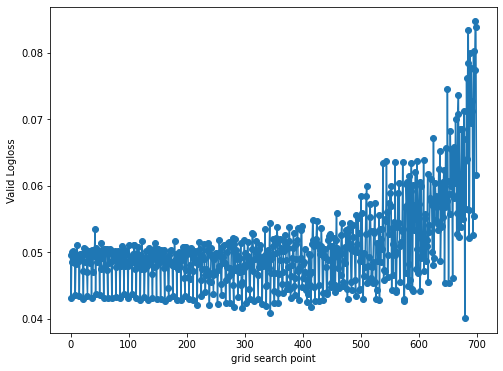

In [151]:
# Plot Loss vs point in grid search
data_out = 'data_xgb_13LungCancer'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss.csv'))
fig, axes = plt.subplots(figsize=(8,6))
axes.scatter(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.plot(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.set_xlabel("grid search point")
axes.set_ylabel("Valid Logloss")
plt.show()

In [181]:
# Train with best hyperparameters
param[0] = ('eta', best_eta)
param[1] = ('max_depth', best_depth)

evals_result = {}
xgb_clf = xgb.train(param, dtrain, 
                    num_boost_round = 5000, 
                    evals = valid_list, 
                    early_stopping_rounds = 100, 
                    verbose_eval = True, 
                    evals_result=evals_result)

[0]	train-logloss:0.61406	valid-logloss:0.61438
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.54884	valid-logloss:0.54865
[2]	train-logloss:0.49382	valid-logloss:0.49434
[3]	train-logloss:0.44713	valid-logloss:0.44775
[4]	train-logloss:0.40710	valid-logloss:0.40797
[5]	train-logloss:0.37242	valid-logloss:0.37356
[6]	train-logloss:0.34239	valid-logloss:0.34335
[7]	train-logloss:0.31597	valid-logloss:0.31760
[8]	train-logloss:0.29270	valid-logloss:0.29336
[9]	train-logloss:0.27220	valid-logloss:0.27290
[10]	train-logloss:0.25387	valid-logloss:0.25497
[11]	train-logloss:0.23675	valid-logloss:0.23838
[12]	train-logloss:0.22165	valid-logloss:0.22332
[13]	train-logloss:0.20807	valid-logloss:0.21001
[14]	train-logloss:0.19609	valid-logloss:0.19804
[15]	train-logloss:0.18519	valid-logloss:0.18721
[16]	train-logloss:0.17573	valid-logloss:0.17788
[17]	train-logloss:0.1667

[164]	train-logloss:0.01298	valid-logloss:0.04668
[165]	train-logloss:0.01283	valid-logloss:0.04665
[166]	train-logloss:0.01268	valid-logloss:0.04650
[167]	train-logloss:0.01260	valid-logloss:0.04645
[168]	train-logloss:0.01241	valid-logloss:0.04646
[169]	train-logloss:0.01225	valid-logloss:0.04660
[170]	train-logloss:0.01213	valid-logloss:0.04642
[171]	train-logloss:0.01205	valid-logloss:0.04638
[172]	train-logloss:0.01189	valid-logloss:0.04620
[173]	train-logloss:0.01174	valid-logloss:0.04626
[174]	train-logloss:0.01162	valid-logloss:0.04615
[175]	train-logloss:0.01150	valid-logloss:0.04603
[176]	train-logloss:0.01139	valid-logloss:0.04585
[177]	train-logloss:0.01128	valid-logloss:0.04558
[178]	train-logloss:0.01112	valid-logloss:0.04532
[179]	train-logloss:0.01101	valid-logloss:0.04526
[180]	train-logloss:0.01087	valid-logloss:0.04543
[181]	train-logloss:0.01080	valid-logloss:0.04518
[182]	train-logloss:0.01069	valid-logloss:0.04515
[183]	train-logloss:0.01060	valid-logloss:0.04519


[328]	train-logloss:0.00314	valid-logloss:0.04129
[329]	train-logloss:0.00312	valid-logloss:0.04135
[330]	train-logloss:0.00309	valid-logloss:0.04148
[331]	train-logloss:0.00308	valid-logloss:0.04145
[332]	train-logloss:0.00305	valid-logloss:0.04140
[333]	train-logloss:0.00304	valid-logloss:0.04126
[334]	train-logloss:0.00303	valid-logloss:0.04124
[335]	train-logloss:0.00301	valid-logloss:0.04128
[336]	train-logloss:0.00300	valid-logloss:0.04132
[337]	train-logloss:0.00297	valid-logloss:0.04151
[338]	train-logloss:0.00295	valid-logloss:0.04153
[339]	train-logloss:0.00294	valid-logloss:0.04140
[340]	train-logloss:0.00292	valid-logloss:0.04134
[341]	train-logloss:0.00290	valid-logloss:0.04133
[342]	train-logloss:0.00288	valid-logloss:0.04128
[343]	train-logloss:0.00286	valid-logloss:0.04127
[344]	train-logloss:0.00284	valid-logloss:0.04136
[345]	train-logloss:0.00283	valid-logloss:0.04134
[346]	train-logloss:0.00281	valid-logloss:0.04141
[347]	train-logloss:0.00280	valid-logloss:0.04136


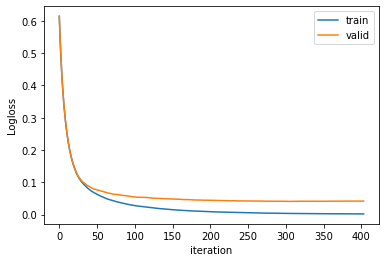

In [182]:
# Plot of train/valid loss vs iter
fig, axes = plt.subplots(figsize=(6,4))
axes.plot(evals_result['train']['logloss'], label="train")
axes.plot(evals_result['valid']['logloss'], label="valid")
axes.legend()
axes.set_ylabel("Logloss")
axes.set_xlabel("iteration")
# axes.set_xticks(np.arange(0, len(evals_result['train']['logloss']), 1))
plt.show()

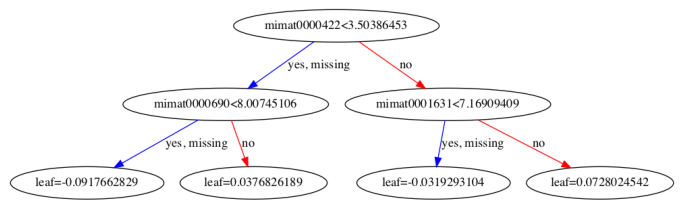

In [183]:
# Plot tree(s)
fig, axes = plt.subplots(figsize=(12,10))
plot_tree(xgb_clf, ax=axes, num_trees=26)
plt.show()

In [184]:
# Save model and model's best params
data_out = 'data_xgb_13LungCancer'
xgb_clf.save_model(os.path.join(data_out, 'xgb_model.json'))
print("model saved at: '{}'".format(os.path.join(data_out, 'xgb_model.json')))

best_params = {}
best_params['best_eta'] = best_eta
best_params['best_depth'] = int(best_depth)
with open(os.path.join(data_out, 'xgb_best_params.json'), 'w') as f:
    json.dump(best_params, f)
print("best params saved at: '{}'".format(os.path.join(data_out, 'xgb_best_params.json')))

model saved at: 'data_xgb_13LungCancer/xgb_model.json'
best params saved at: 'data_xgb_13LungCancer/xgb_best_params.json'


In [197]:
# Save feature map
def ceate_feature_map(features, data_out):
    f = open(os.path.join(data_out, 'xgb_model_fmap.txt'), 'w')
    i = 0
    for feat in features:
        f.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    f.close()

data_out = 'data_xgb_13LungCancer'
ceate_feature_map(cols_all, data_out)
print("feature map saved at: '{}'".format(os.path.join(data_out, 'xgb_model_fmap.txt')))

feature map saved at: 'data_xgb_13LungCancer/xgb_model_fmap.txt'


In [198]:
# Find MSE, R2, Accuracy, etc...
data_out = 'data_xgb_13LungCancer'
model = xgb.Booster(model_file=os.path.join(data_out, 'xgb_model.json'))
df_results = pd.DataFrame(index=['train', 'valid', 'test'], 
                           columns=['accuracy', 'roc_auc'])

ypred = model.predict(dtrain)
ypred = ypred.round().astype(int)
df_results.loc['train', 'accuracy'] = accuracy_score(ytrain, ypred)
df_results.loc['train', 'roc_auc']  = roc_auc_score(ytrain, ypred)

ypred = model.predict(dvalid)
ypred = ypred.round().astype(int)
df_results.loc['valid', 'accuracy'] = accuracy_score(yvalid, ypred)
df_results.loc['valid', 'roc_auc']  = roc_auc_score(yvalid, ypred)

ypred = model.predict(dtest)
ypred = ypred.round().astype(int)
df_results.loc['test', 'accuracy'] = accuracy_score(ytest, ypred)
df_results.loc['test', 'roc_auc']  = roc_auc_score(ytest, ypred)

# Save data
df_results.to_csv(os.path.join(data_out, 'results_target_xgb.csv'), index=True)
print("model results saved at: '{}'".format(os.path.join(data_out, 'results_target_xgb.csv')))
df_results.head()

model results saved at: 'data_xgb_13LungCancer/results_target_xgb.csv'


,accuracy,roc_auc
train,1,1
valid,0.982644,0.98182
test,0.981308,0.983406


In [201]:
# Find Accuracy +/- STD
data_in  = 'data_xgb_13LungCancer'
data_out = 'data_xgb_13LungCancer/partitions'
df_results = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 'train_roc', 'valid_roc', 'test_roc'])

with open(os.path.join(data_in, 'xgb_best_params.json')) as f:
    best_params = json.load(f)
param = [('eta', best_params['best_eta']), 
         ('max_depth', best_params['best_depth']), 
         ('objective', 'binary:logistic'), 
         ('nthread', 16),
         ('eval_metric', 'logloss')
]

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
X = pd.read_csv('dataset_13LungCancer/X.csv', header=None)
y = pd.read_csv('dataset_13LungCancer/y.csv', header=None)
for n in iterator:
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])
    
# .build DMatrices
    dtrain = xgb.DMatrix(data=xtrain, label=ytrain, nthread=16)
    dvalid = xgb.DMatrix(data=xvalid, label=yvalid, nthread=16)
    dtest  = xgb.DMatrix(data=xtest,  label=ytest,  nthread=16)
    valid_list = [(dtrain, 'train'), (dvalid, 'valid')]

# .train model
    evals_result = {}
    model = xgb.train(param, dtrain, 
                      num_boost_round = 5000, 
                      evals = valid_list, 
                      early_stopping_rounds = 20, 
                      verbose_eval = False, 
                      evals_result=evals_result)
    
# .compute/save accuracy
    ypred = model.predict(dtrain)
    ypred = ypred.round().astype(int)
    df_results.loc[n, 'train_acc'] = accuracy_score(ytrain, ypred)
    df_results.loc[n, 'train_roc']  = roc_auc_score(ytrain, ypred)

    ypred = model.predict(dvalid)
    ypred = ypred.round().astype(int)
    df_results.loc[n, 'valid_acc'] = accuracy_score(yvalid, ypred)
    df_results.loc[n, 'valid_roc']  = roc_auc_score(yvalid, ypred)

    ypred = model.predict(dtest)
    ypred = ypred.round().astype(int)
    df_results.loc[n, 'test_acc'] = accuracy_score(ytest, ypred)
    df_results.loc[n, 'test_roc']  = roc_auc_score(ytest, ypred)

    model.save_model(os.path.join(data_out, 'xgb_model_'+str(n)+'.json'))
    df_results.to_csv(os.path.join(data_out, 'accuracy_xgb.csv'), index=None)

Partitions loop:   0%|          | 0/100 [00:00<?, ?it/s]

In [202]:
# Display results
data_out = 'data_xgb_13LungCancer'
accuracy_xgb = pd.read_csv(os.path.join(data_out, 'accuracy13_xgb.csv'))
print("Train accuracy = {:.3f} +/- {:.3f}".format(accuracy_xgb['train_acc'].mean(), 
                                                  accuracy_xgb['train_acc'].std()))
print("Valid accuracy = {:.3f} +/- {:.3f}".format(accuracy_xgb['valid_acc'].mean(), 
                                                  accuracy_xgb['valid_acc'].std()))
print("Test accuracy = {:.3f} +/- {:.3f}".format(accuracy_xgb['test_acc'].mean(), 
                                                 accuracy_xgb['test_acc'].std()))

Train accuracy = 1.000 +/- 0.000
Valid accuracy = 0.981 +/- 0.006
Test accuracy = 0.981 +/- 0.005


* ### Lockdown

In [23]:
# Normalize Data Set
def normalize_data():
    """
    """
    global xtrain, xvalid, xtest
    scaler = StandardScaler()
    scaler.fit(xtrain.numpy())
    xtrain = torch.from_numpy(scaler.transform(xtrain.numpy()))
    xvalid = torch.from_numpy(scaler.transform(xvalid.numpy()))
    xtest = torch.from_numpy(scaler.transform(xtest.numpy()))

In [24]:
# Save output data
def save_output(data_out, f1, f2, f3, new_folder=False):
    """
    """
# Save relevant data
    if new_folder == True:
        dirs = os.listdir()
        if data_out in dirs:
            print("'{}' directory deleted.".format(data_out))
            shutil.rmtree(data_out)
            print("'{}' directory created.\n".format(data_out))
            os.mkdir(data_out)
        else:
            print("'{}' directory created.\n".format(data_out))
            os.mkdir(data_out)
# 
    train_loss.to_csv(os.path.join(data_out, f1), index=False)
    valid_loss.to_csv(os.path.join(data_out, f2), index=False)
    print("'{}' saved.".format(f1))
    print("'{}' saved.".format(f2))

    for m in f3:
        shutil.move(m, os.path.join(data_out, m))
        print("'{}' saved.".format(m))

* #### l1=5, l2=2; lockdown=l1

In [25]:
# Set layers where lockdown is to be applied
def get_lockdown_layers(model):
    layers = [model.classifier[0]]
    return layers

In [26]:
#  NN architecture with its corresponding forward method
class MyNet(nn.Module):
    
# .Network architecture
    def __init__(self, features, layer_sizes):
        super(MyNet, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(features, layer_sizes[0], bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(layer_sizes[0], layer_sizes[1], bias=True)
        )

# .Forward function
    def forward(self, x):
        x = self.classifier(x)
        return x

In [119]:
# Grid search space
grid_lrs = np.geomspace(5e-4, 1e-1, num=10)
df_grid_loss = pd.DataFrame(columns = ['lr', 'valid_loss', 'valid_acc'], 
                            index=range(len(grid_lrs)))

In [120]:
# Perform grid search (unconstrained)
layer_sizes = [5, 2]
epochs = 50000
data_in = 'dataset_13LungCancer'
data_out = "data_unconstrained_13LungCancer/lrs"
lock_flag = False

# Read data
load_data(data_in)

# Normalize data
normalize_data()

# Create DataLoaders
make_DataLoaders()
features = xtrain.size(1)

# Train model
iterator = tqdm.notebook.tqdm(range(1, len(grid_lrs) + 1), desc='lr-grid loop')
for n in iterator:
    irow = n-1
    fname = 'model13_forward05_'+str(n)
    train_loss, valid_loss = train_model(
                             grid_lrs[irow], 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs=epochs,
                             early_stop=epochs, 
                             fname=fname)
    print('\nBest train loss = {:.7f}\n'.format(train_loss['loss'].min()))

# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_loss05_'+str(n)+'.csv', 
                'valid_loss05_'+str(n)+'.csv', f3)
    
# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()

# .save grid search results
    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    df_grid_loss.iloc[irow,:] = [grid_lrs[irow], loss.detach().item(), accu]
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_forward05.csv'), index=None)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


lr-grid loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00050
-Model saved after iteration 50000.
-Train.  Loss=0.0374694
-Valid.  Loss=0.0721759

Best train loss = 0.0374694

'train_loss05_1.csv' saved.
'valid_loss05_1.csv' saved.
'model13_forward05_1_last.pth' saved.
'model13_forward05_1_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00090
-Model saved after iteration 50000.
-Train.  Loss=0.0177359
-Valid.  Loss=0.0673790

Best train loss = 0.0177359

'train_loss05_2.csv' saved.
'valid_loss05_2.csv' saved.
'model13_forward05_2_last.pth' saved.
'model13_forward05_2_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-Model saved after iteration 31560.
-Train.  Loss=0.0150918
-Valid.  Loss=0.0672074

Best train loss = 0.0089321

'train_loss05_3.csv' saved.
'valid_loss05_3.csv' saved.
'model13_forward05_3_last.pth' saved.
'model13_forward05_3_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 17516.
-Train.  Loss=0.0150948
-Valid.  Loss=0.0672053

Best train loss = 0.0051252

'train_loss05_4.csv' saved.
'valid_loss05_4.csv' saved.
'model13_forward05_4_last.pth' saved.
'model13_forward05_4_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9742.
-Train.  Loss=0.0150590
-Valid.  Loss=0.0671993

Best train loss = 0.0032547

'train_loss05_5.csv' saved.
'valid_loss05_5.csv' saved.
'model13_forward05_5_last.pth' saved.
'model13_forward05_5_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00949
-Model saved after iteration 5409.
-Train.  Loss=0.0150580
-Valid.  Loss=0.0671953

Best train loss = 0.0026226

'train_loss05_6.csv' saved.
'valid_loss05_6.csv' saved.
'model13_forward05_6_last.pth' saved.
'model13_forward05_6_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.01710
-Model saved after iteration 3004.
-Train.  Loss=0.0150563
-Valid.  Loss=0.0671888

Best train loss = 0.0023577

'train_loss05_7.csv' saved.
'valid_loss05_7.csv' saved.
'model13_forward05_7_last.pth' saved.
'model13_forward05_7_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.03081
-Model saved after iteration 1671.
-Train.  Loss=0.0150350
-Valid.  Loss=0.0671765

Best train loss = 0.0022367

'train_loss05_8.csv' saved.
'valid_loss05_8.csv' saved.
'model13_forward05_8_last.pth' saved.
'model13_forward05_8_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 916.
-Train.  Loss=0.0153061
-Valid.  Loss=0.0671560

Best train loss = 0.0021783

'train_loss05_9.csv' saved.
'valid_loss05_9.csv' saved.
'model13_forward05_9_last.pth' saved.
'model13_forward05_9_best.pth' saved.


Epochs loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-Model saved after iteration 512.
-Train.  Loss=0.0152548
-Valid.  Loss=0.0670715

Best train loss = 0.0010663

'train_loss05_10.csv' saved.
'valid_loss05_10.csv' saved.
'model13_forward05_10_last.pth' saved.
'model13_forward05_10_best.pth' saved.


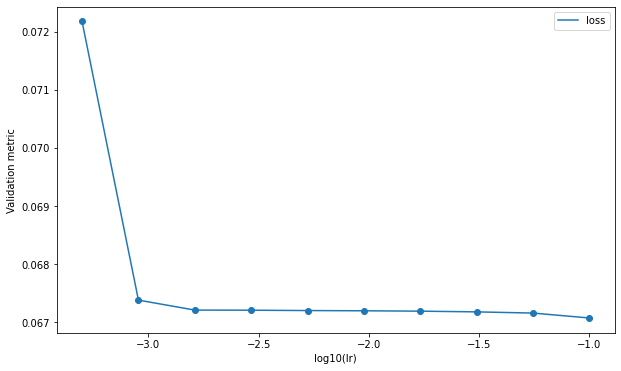

In [122]:
# Plot Loss vs point in grid search
data_out = "data_unconstrained_13LungCancer/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_forward05.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_loss'])
axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_loss'], label='loss')
# axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'])
# axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'], label='r2')
axes.set_xlabel("log10(lr)")
axes.set_ylabel("Validation metric")
axes.legend()
plt.show()

In [123]:
# Display grid search results
data_out = "data_unconstrained_13LungCancer/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_forward05.csv'))

idx = df_grid_loss.valid_loss.idxmin()
best_lr_fward = df_grid_loss.iloc[idx, 0]
best_mse      = df_grid_loss.iloc[idx, 1]
print("Best parameters ({}):".format(idx+1))
print("- Best lr = {:.5f}".format(best_lr_fward))
print("- Best valid loss = {}".format(best_mse))

# Copy best model to main directory
shutil.copy("data_unconstrained_13LungCancer/lrs/model13_forward05_"+str(idx+1)+"_best.pth", 
            "data_unconstrained_13LungCancer/model13_forward05_best.pth")
shutil.copy("data_unconstrained_13LungCancer/lrs/model13_forward05_"+str(idx+1)+"_last.pth", 
            "data_unconstrained_13LungCancer/model13_forward05_last.pth")

shutil.copy("data_unconstrained_13LungCancer/lrs/train_loss05_"+str(idx+1)+".csv", 
            "data_unconstrained_13LungCancer/train_loss05.csv")
shutil.copy("data_unconstrained_13LungCancer/lrs/valid_loss05_"+str(idx+1)+".csv", 
            "data_unconstrained_13LungCancer/valid_loss05.csv")

Best parameters (10):
- Best lr = 0.10000
- Best valid loss = 0.06707156449556351


'data_unconstrained_13LungCancer/valid_loss05.csv'

In [126]:
# Grid search space
grid_lrs = np.geomspace(5e-4, 1e-1, num=10)
df_grid_loss = pd.DataFrame(columns = ['lr', 'valid_loss', 'valid_acc'], 
                            index=range(len(grid_lrs)))

In [127]:
# Perform grid search (lockdown: path 2)
layer_sizes = [5, 2]
epochs = 10000
data_in = 'dataset_13LungCancer'
data_out = "data_lockdown_13LungCancer/lrs"
lock_flag = True
step = 1

# Read data
load_data(data_in)

# Normalize data
normalize_data()

# Create DataLoaders
make_DataLoaders()
features = xtrain.size(1)

# Train model
iterator = tqdm.notebook.tqdm(range(1, len(grid_lrs) + 1), desc='lr-grid loop')
for n in iterator:
    irow = n-1
    model_forward_name = 'data_unconstrained_13LungCancer/lrs/model13_forward05_'+str(n)+'_last.pth'
    fname = 'model13_backward05_'+str(n)
    train_loss, valid_loss = train_model(
                             grid_lrs[irow], 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs=epochs,
                             early_stop=epochs, 
                             fname=fname)
    print('\nBest train loss = {:.7f}\n'.format(train_loss['loss'].min()))

# .save relevant data
    f3 = [fname+'_best.pth']
    save_output(data_out, 
                'train_loss05_'+str(n)+'.csv', 
                'valid_loss05_'+str(n)+'.csv', f3)
    
# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()

# .save grid search results
    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    df_grid_loss.iloc[irow,:] = [grid_lrs[irow], loss.detach().item(), accu]
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_backward05.csv'), index=None)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


lr-grid loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00050
-Model saved after iteration 5416.
-Train.  Loss=0.0248306
-Valid.  Loss=0.0536819

Best train loss = 0.0182633

'train_loss05_1.csv' saved.
'valid_loss05_1.csv' saved.
'model13_backward05_1_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00090
-Model saved after iteration 6660.
-Train.  Loss=0.0196311
-Valid.  Loss=0.0486038

Best train loss = 0.0073197

'train_loss05_2.csv' saved.
'valid_loss05_2.csv' saved.
'model13_backward05_2_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-Model saved after iteration 7144.
-Train.  Loss=0.0152456
-Valid.  Loss=0.0461635

Best train loss = 0.0034572

'train_loss05_3.csv' saved.
'valid_loss05_3.csv' saved.
'model13_backward05_3_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 7427.
-Train.  Loss=0.0120842
-Valid.  Loss=0.0447339

Best train loss = 0.0023240

'train_loss05_4.csv' saved.
'valid_loss05_4.csv' saved.
'model13_backward05_4_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8233.
-Train.  Loss=0.0170905
-Valid.  Loss=0.0422992

Best train loss = 0.0019299

'train_loss05_5.csv' saved.
'valid_loss05_5.csv' saved.
'model13_backward05_5_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00949
-Model saved after iteration 8979.
-Train.  Loss=0.0282080
-Valid.  Loss=0.0475971

Best train loss = 0.0018368

'train_loss05_6.csv' saved.
'valid_loss05_6.csv' saved.
'model13_backward05_6_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.01710
-Model saved after iteration 9265.
-Train.  Loss=0.0345687
-Valid.  Loss=0.0488183

Best train loss = 0.0019125

'train_loss05_7.csv' saved.
'valid_loss05_7.csv' saved.
'model13_backward05_7_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.03081
-Model saved after iteration 9569.
-Train.  Loss=0.0458497
-Valid.  Loss=0.0552858

Best train loss = 0.0018353

'train_loss05_8.csv' saved.
'valid_loss05_8.csv' saved.
'model13_backward05_8_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 9769.
-Train.  Loss=0.0648041
-Valid.  Loss=0.0610051

Best train loss = 0.0019328

'train_loss05_9.csv' saved.
'valid_loss05_9.csv' saved.
'model13_backward05_9_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-Model saved after iteration 9502.
-Train.  Loss=0.0697413
-Valid.  Loss=0.0636000

Best train loss = 0.0010664

'train_loss05_10.csv' saved.
'valid_loss05_10.csv' saved.
'model13_backward05_10_best.pth' saved.


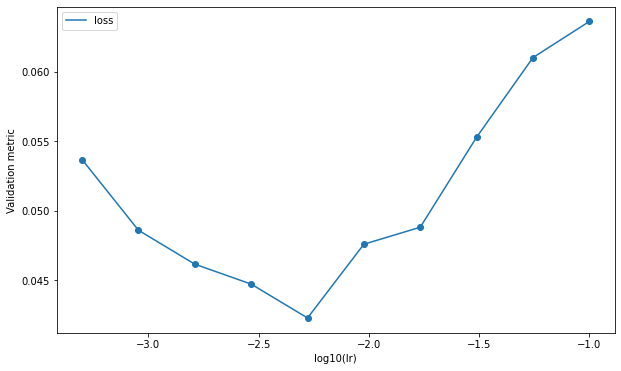

In [128]:
# Plot Loss vs point in grid search
data_out = "data_lockdown_13LungCancer/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_backward05.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_loss'])
axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_loss'], label='loss')
# axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'])
# axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'], label='r2')
axes.set_xlabel("log10(lr)")
axes.set_ylabel("Validation metric")
axes.legend()
plt.show()

In [129]:
# Display grid search results
data_out = "data_lockdown_13LungCancer/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_backward05.csv'))

idx = df_grid_loss.valid_loss.idxmin()
# idx = df_grid_loss.valid_acc.idxmax()
best_lr_bward = df_grid_loss.iloc[idx, 0]
best_mse      = df_grid_loss.iloc[idx, 1]
print("Best parameters ({}):".format(idx+1))
print("- Best lr = {:.5f}".format(best_lr_bward))
print("- Best valid loss = {}".format(best_mse))

# Copy best models to main directory
shutil.copy("data_unconstrained_13LungCancer/lrs/model13_forward05_"+str(idx+1)+"_best.pth", 
            "data_lockdown_13LungCancer/model13_fward05_best.pth")
shutil.copy("data_unconstrained_13LungCancer/lrs/model13_forward05_"+str(idx+1)+"_last.pth", 
            "data_lockdown_13LungCancer/model13_fward05_last.pth")
shutil.copy("data_lockdown_13LungCancer/lrs/model13_backward05_"+str(idx+1)+"_best.pth", 
            "data_lockdown_13LungCancer/model13_backward05_best.pth")

shutil.copy("data_unconstrained_13LungCancer/lrs/train_loss05_"+str(idx+1)+".csv", 
            "data_lockdown_13LungCancer/train_loss_fward05.csv")
shutil.copy("data_unconstrained_13LungCancer/lrs/valid_loss05_"+str(idx+1)+".csv", 
            "data_lockdown_13LungCancer/valid_loss_fward05.csv")
shutil.copy("data_lockdown_13LungCancer/lrs/train_loss05_"+str(idx+1)+".csv", 
            "data_lockdown_13LungCancer/train_loss05.csv")
shutil.copy("data_lockdown_13LungCancer/lrs/valid_loss05_"+str(idx+1)+".csv", 
            "data_lockdown_13LungCancer/valid_loss05.csv")

Best parameters (5):
- Best lr = 0.00527
- Best valid loss = 0.04229918122291565


'data_lockdown_13LungCancer/valid_loss05.csv'

In [130]:
# Find Loss, Accuracy, etc...
layer_sizes = [5, 2]
data_out = "data_lockdown_13LungCancer"
index = pd.MultiIndex.from_product([['TRAIN', 'VALIDATION', 'TEST'], ['forward', 'lockdown']])
df_results = pd.DataFrame(index=index, columns=['LOSS', 'ACCURACY'])

# Unconstrained results
mm = MyNet(features, layer_sizes)
mm.load_state_dict(torch.load('data_unconstrained_13LungCancer/model13_forward05_best.pth'))
mm = mm.to(device)
mm.eval()

ypred = mm(xtrain)
loss = loss_type(ypred, ytrain.view(-1))
accu = dataset_accuracy(train_dataloader, mm, device)
df_results.loc[('TRAIN', 'forward'), 'LOSS'] = loss.detach().item()
df_results.loc[('TRAIN', 'forward'), 'ACCURACY'] = accu

ypred = mm(xvalid)
loss = loss_type(ypred, yvalid.view(-1))
accu = dataset_accuracy(valid_dataloader, mm, device)
df_results.loc[('VALIDATION', 'forward'), 'LOSS'] = loss.detach().item()
df_results.loc[('VALIDATION', 'forward'), 'ACCURACY'] = accu

ypred = mm(xtest)
loss = loss_type(ypred, ytest.view(-1))
accu = dataset_accuracy(test_dataloader, mm, device)
df_results.loc[('TEST', 'forward'), 'LOSS'] = loss.detach().item()
df_results.loc[('TEST', 'forward'), 'ACCURACY'] = accu

# Lockdown results
mm = MyNet(features, layer_sizes)
mm.load_state_dict(torch.load('data_lockdown_13LungCancer/model13_backward05_best.pth'))
mm = mm.to(device)
mm.eval()

ypred = mm(xtrain)
loss = loss_type(ypred, ytrain.view(-1))
accu = dataset_accuracy(train_dataloader, mm, device)
df_results.loc[('TRAIN', 'lockdown'), 'LOSS'] = loss.detach().item()
df_results.loc[('TRAIN', 'lockdown'), 'ACCURACY'] = accu

ypred = mm(xvalid)
loss = loss_type(ypred, yvalid.view(-1))
accu = dataset_accuracy(valid_dataloader, mm, device)
df_results.loc[('VALIDATION', 'lockdown'), 'LOSS'] = loss.detach().item()
df_results.loc[('VALIDATION', 'lockdown'), 'ACCURACY'] = accu

ypred = mm(xtest)
loss = loss_type(ypred, ytest.view(-1))
accu = dataset_accuracy(test_dataloader, mm, device)
df_results.loc[('TEST', 'lockdown'), 'LOSS'] = loss.detach().item()
df_results.loc[('TEST', 'lockdown'), 'ACCURACY'] = accu

df_results.to_csv(os.path.join(data_out, 'results05.csv'), index=True)
df_results

LOSS  ACCURACY
TRAIN      forward   0.0152548   0.99911
           lockdown  0.0170906  0.998219
VALIDATION forward   0.0670716  0.975968
           lockdown  0.0422992  0.985314
TEST       forward   0.0595673  0.978638
           lockdown  0.0558264  0.971963

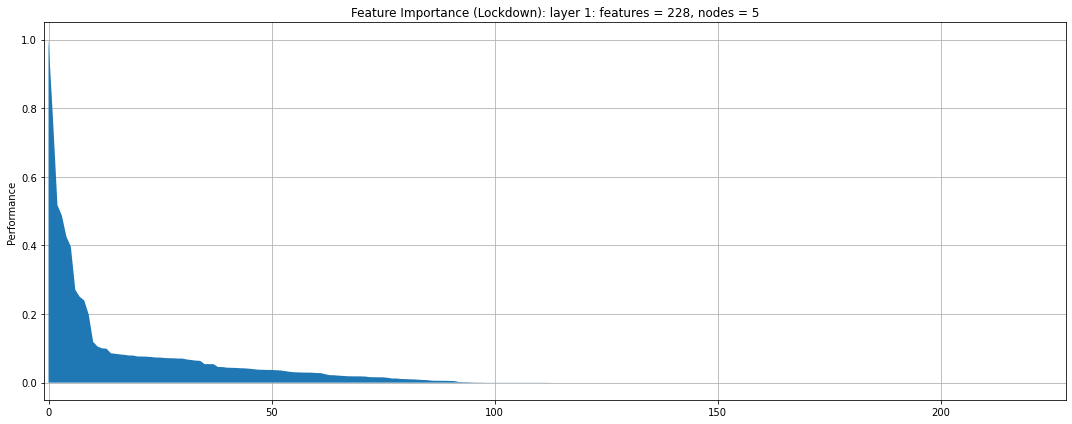

Feature importance graph saved at: 'data_lockdown_13LungCancer/feature_importance05.pdf'
feature importance .csv saved at: 'data_lockdown_13LungCancer/feature_importance_lockdown05.csv'


In [131]:
# Weight importance (Lockdown: layer 1)
data_out = "data_lockdown_13LungCancer"
m1 = torch.load('data_lockdown_13LungCancer/model13_backward05_best.pth')
feature_importance1 = pd.Series(abs(m1['classifier.0.weight']).sum(dim=0), index=cols_all)
feature_importance1 = feature_importance1/feature_importance1.max()
feature_importance_sorted1 = feature_importance1.sort_values(ascending=False)

idx = feature_importance_sorted1 >= 0

fig, axes = plt.subplots(figsize=(15,6))
x_pos = np.arange(idx.sum())
axes.fill_between(x_pos, 0, feature_importance_sorted1[idx], zorder=2)
# axes.bar(x_pos, feature_importance_sorted1[idx], zorder=2)
# axes.set_xticks(x_pos)
# axes.set_xticklabels(feature_importance_sorted1.index[idx], rotation='vertical')
axes.set_xlim(-1,idx.sum())
axes.set_ylabel('Performance')
axes.set_title('Feature Importance (Lockdown): layer 1: features = {}, nodes = {}'.format(n_features, 
                                                                                          layer_sizes[0]))
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig(os.path.join(data_out, 'feature_importance05.pdf'), bbox_inches='tight')
plt.show()
print("Feature importance graph saved at: '{}'".format(os.path.join(data_out, 'feature_importance05.pdf')))

feature_importance_sorted1.to_csv(os.path.join(data_out, 'feature_importance_lockdown05.csv'))
print("feature importance .csv saved at: '{}'".format(os.path.join(data_out, 'feature_importance_lockdown05.csv')))

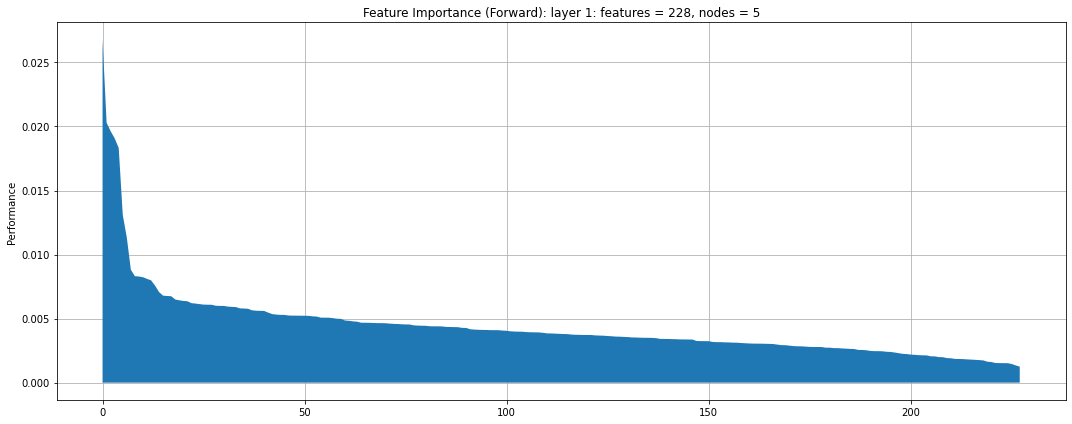

Feature importance graph saved at: 'data_unconstrained_13LungCancer/feature_importance05.pdf'
feature importance .csv saved at: 'data_unconstrained_13LungCancer/feature_importance_forward05.csv'


In [125]:
# Weight importance (Forward: layer 1)
data_out = "data_unconstrained_13LungCancer"
m1 = torch.load('data_unconstrained_13LungCancer/model13_forward05_best.pth')
feature_importance1 = pd.Series(abs(m1['classifier.0.weight']).sum(dim=0), index=cols_all)
feature_importance1 = feature_importance1/feature_importance1.sum()
feature_importance_sorted1 = feature_importance1.sort_values(ascending=False)

idx = feature_importance_sorted1 >= 0

fig, axes = plt.subplots(figsize=(15,6))
x_pos = np.arange(idx.sum())
axes.fill_between(x_pos, 0, feature_importance_sorted1[idx], zorder=2, lw=3)
# axes.set_xticks(x_pos)
# axes.set_xticklabels(feature_importance_sorted1.index[idx], rotation='vertical')
# axes.set_xlim(-1,idx.sum())
axes.set_ylabel('Performance')
axes.set_title('Feature Importance (Forward): layer 1: features = {}, nodes = {}'.format(n_features, 
                                                                                          layer_sizes[0]))
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig(os.path.join(data_out, 'feature_importance05.pdf'), bbox_inches='tight')
plt.show()
print("Feature importance graph saved at: '{}'".format(os.path.join(data_out, 'feature_importance05.pdf')))

feature_importance_sorted1.to_csv(os.path.join(data_out, 'feature_importance_forward05.csv'))
print("feature importance .csv saved at: '{}'".format(os.path.join(data_out, 'feature_importance_forward05.csv')))

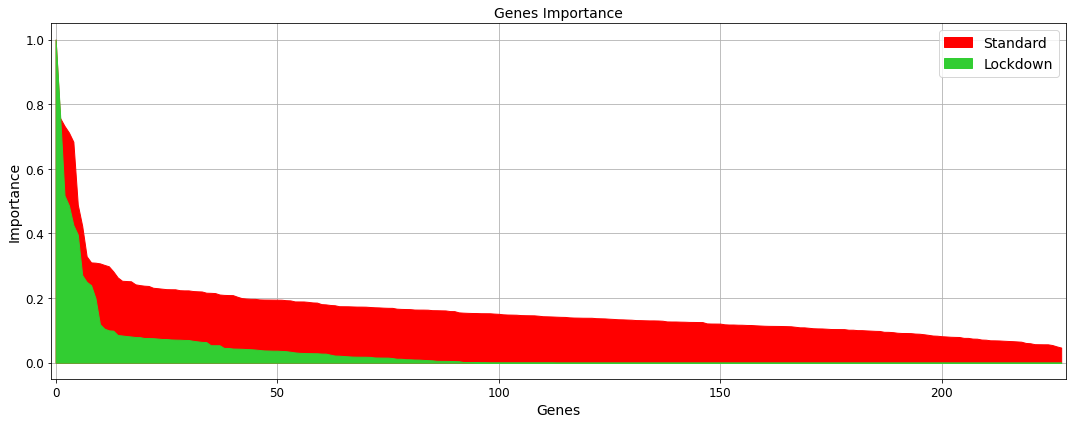

In [133]:
# Gene importance
data_out = "data_lockdown_13LungCancer"
m1 = torch.load('data_lockdown_13LungCancer/model13_backward05_best.pth')
feature_importance1 = pd.Series(abs(m1['classifier.0.weight']).sum(dim=0), index=cols_all)
feature_importance1 = feature_importance1/feature_importance1.max()
feature_importance_sorted1 = feature_importance1.sort_values(ascending=False)
idx1 = feature_importance_sorted1 >= 0

data_out = "data_unconstrained_13LungCancer"
m2 = torch.load('data_unconstrained_13LungCancer/model13_forward05_best.pth')
feature_importance2 = pd.Series(abs(m2['classifier.0.weight']).sum(dim=0), index=cols_all)
feature_importance2 = feature_importance2/feature_importance2.max()
feature_importance_sorted2 = feature_importance2.sort_values(ascending=False)
idx2 = feature_importance_sorted2 >= 0

fig, axes = plt.subplots(figsize=(15,6))
x_pos = np.arange(idx2.sum())
axes.fill_between(x_pos, 0, feature_importance_sorted2[idx2], label='Standard', zorder=2, color='red')
axes.fill_between(x_pos, 0, feature_importance_sorted1[idx1], label='Lockdown', zorder=2, color='limegreen')
axes.set_xlim(-1,idx.sum())
axes.set_ylabel('Importance', fontsize=14)
axes.set_xlabel('Genes', fontsize=14)
# axes.set_title('Genes Importance: genes = {}'.format(features), fontsize=14)
axes.set_title('Genes Importance', fontsize=14)
axes.legend(fontsize=14)
axes.grid(True, zorder=1)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

data_out = "data_lockdown_13LungCancer"
plt.tight_layout()
plt.savefig(os.path.join(data_out, 'feature_importance.pdf'), bbox_inches='tight')
plt.show()
# print("Feature importance graph saved at: '{}'".format(os.path.join(data_out, 'feature_importance05.pdf')))

# feature_importance_sorted1.to_csv(os.path.join(data_out, 'feature_importance_lockdown05.csv'))
# print("feature importance .csv saved at: '{}'".format(os.path.join(data_out, 'feature_importance_lockdown05.csv')))

In [135]:
# Find Accuracy, Loss +/- STD (Forward)
data_output = 'data_unconstrained_13LungCancer'
accuracy_forward = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 
                                         'train_loss', 'valid_loss', 'test_loss'])

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_13LungCancer/X.csv', header=None)
    y = pd.read_csv('dataset_13LungCancer/y.csv', header=None)
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders()

# .train model (forward)
    lr = best_lr_fward
    layer_sizes = [5, 2]
    epochs = 40000
    data_out = "data_unconstrained_13LungCancer/partitions"
    lock_flag = False
    features = xtrain.size(1)
    fname = 'model13_forward05_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = 8000, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_loss05_'+str(n)+'.csv', 
                'valid_loss05_'+str(n)+'.csv', f3)

# .find Loss, Accurary, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    loss = loss_type(ypred, ytrain.view(-1))
    accu = dataset_accuracy(train_dataloader, mm, device)
    accuracy_forward.loc[n, 'train_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'train_acc'] = accu

    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    accuracy_forward.loc[n, 'valid_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'valid_acc'] = accu

    ypred = mm(xtest)
    loss = loss_type(ypred, ytest.view(-1))
    accu = dataset_accuracy(test_dataloader, mm, device)
    accuracy_forward.loc[n, 'test_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'test_acc'] = accu

    accuracy_forward.to_csv(os.path.join(data_output, 'accuracy13_forward05.csv'), index=True)

Partitions loop:   0%|          | 0/100 [00:00<?, ?it/s]

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 2095.
-Train.  Loss=0.0045287
-Valid.  Loss=0.0474883
'train_loss05_1.csv' saved.
'valid_loss05_1.csv' saved.
'model13_forward05_1_last.pth' saved.
'model13_forward05_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 683.
-Train.  Loss=0.0113633
-Valid.  Loss=0.0634574
'train_loss05_2.csv' saved.
'valid_loss05_2.csv' saved.
'model13_forward05_2_last.pth' saved.
'model13_forward05_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 673.
-Train.  Loss=0.0131478
-Valid.  Loss=0.0613100
'train_loss05_3.csv' saved.
'valid_loss05_3.csv' saved.
'model13_forward05_3_last.pth' saved.
'model13_forward05_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 424.
-Train.  Loss=0.0228017
-Valid.  Loss=0.0777426
'train_loss05_4.csv' saved.
'valid_loss05_4.csv' saved.
'model13_forward05_4_last.pth' saved.
'model13_forward05_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 338.
-Train.  Loss=0.0259218
-Valid.  Loss=0.0808668
'train_loss05_5.csv' saved.
'valid_loss05_5.csv' saved.
'model13_forward05_5_last.pth' saved.
'model13_forward05_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 452.
-Train.  Loss=0.0194932
-Valid.  Loss=0.0942464
'train_loss05_6.csv' saved.
'valid_loss05_6.csv' saved.
'model13_forward05_6_last.pth' saved.
'model13_forward05_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 593.
-Train.  Loss=0.0142955
-Valid.  Loss=0.0519399
'train_loss05_7.csv' saved.
'valid_loss05_7.csv' saved.
'model13_forward05_7_last.pth' saved.
'model13_forward05_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 987.
-Train.  Loss=0.0115375
-Valid.  Loss=0.0504336
'train_loss05_8.csv' saved.
'valid_loss05_8.csv' saved.
'model13_forward05_8_last.pth' saved.
'model13_forward05_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 775.
-Train.  Loss=0.0110979
-Valid.  Loss=0.0657175
'train_loss05_9.csv' saved.
'valid_loss05_9.csv' saved.
'model13_forward05_9_last.pth' saved.
'model13_forward05_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 440.
-Train.  Loss=0.0185638
-Valid.  Loss=0.0797061
'train_loss05_10.csv' saved.
'valid_loss05_10.csv' saved.
'model13_forward05_10_last.pth' saved.
'model13_forward05_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 508.
-Train.  Loss=0.0160430
-Valid.  Loss=0.0619835
'train_loss05_11.csv' saved.
'valid_loss05_11.csv' saved.
'model13_forward05_11_last.pth' saved.
'model13_forward05_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 452.
-Train.  Loss=0.0199355
-Valid.  Loss=0.0715534
'train_loss05_12.csv' saved.
'valid_loss05_12.csv' saved.
'model13_forward05_12_last.pth' saved.
'model13_forward05_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 433.
-Train.  Loss=0.0204547
-Valid.  Loss=0.0713823
'train_loss05_13.csv' saved.
'valid_loss05_13.csv' saved.
'model13_forward05_13_last.pth' saved.
'model13_forward05_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 399.
-Train.  Loss=0.0213335
-Valid.  Loss=0.0835219
'train_loss05_14.csv' saved.
'valid_loss05_14.csv' saved.
'model13_forward05_14_last.pth' saved.
'model13_forward05_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 393.
-Train.  Loss=0.0218555
-Valid.  Loss=0.0705414
'train_loss05_15.csv' saved.
'valid_loss05_15.csv' saved.
'model13_forward05_15_last.pth' saved.
'model13_forward05_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 553.
-Train.  Loss=0.0168608
-Valid.  Loss=0.0528954
'train_loss05_16.csv' saved.
'valid_loss05_16.csv' saved.
'model13_forward05_16_last.pth' saved.
'model13_forward05_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 1123.
-Train.  Loss=0.0070226
-Valid.  Loss=0.0532664
'train_loss05_17.csv' saved.
'valid_loss05_17.csv' saved.
'model13_forward05_17_last.pth' saved.
'model13_forward05_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 328.
-Train.  Loss=0.0290893
-Valid.  Loss=0.0766887
'train_loss05_18.csv' saved.
'valid_loss05_18.csv' saved.
'model13_forward05_18_last.pth' saved.
'model13_forward05_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 395.
-Train.  Loss=0.0226887
-Valid.  Loss=0.0778570
'train_loss05_19.csv' saved.
'valid_loss05_19.csv' saved.
'model13_forward05_19_last.pth' saved.
'model13_forward05_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 1271.
-Train.  Loss=0.0053879
-Valid.  Loss=0.0459194
'train_loss05_20.csv' saved.
'valid_loss05_20.csv' saved.
'model13_forward05_20_last.pth' saved.
'model13_forward05_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 679.
-Train.  Loss=0.0107503
-Valid.  Loss=0.0634884
'train_loss05_21.csv' saved.
'valid_loss05_21.csv' saved.
'model13_forward05_21_last.pth' saved.
'model13_forward05_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 627.
-Train.  Loss=0.0144585
-Valid.  Loss=0.0590608
'train_loss05_22.csv' saved.
'valid_loss05_22.csv' saved.
'model13_forward05_22_last.pth' saved.
'model13_forward05_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 736.
-Train.  Loss=0.0109447
-Valid.  Loss=0.0412561
'train_loss05_23.csv' saved.
'valid_loss05_23.csv' saved.
'model13_forward05_23_last.pth' saved.
'model13_forward05_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 708.
-Train.  Loss=0.0103183
-Valid.  Loss=0.0664393
'train_loss05_24.csv' saved.
'valid_loss05_24.csv' saved.
'model13_forward05_24_last.pth' saved.
'model13_forward05_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 487.
-Train.  Loss=0.0171766
-Valid.  Loss=0.0669320
'train_loss05_25.csv' saved.
'valid_loss05_25.csv' saved.
'model13_forward05_25_last.pth' saved.
'model13_forward05_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 590.
-Train.  Loss=0.0132154
-Valid.  Loss=0.0540786
'train_loss05_26.csv' saved.
'valid_loss05_26.csv' saved.
'model13_forward05_26_last.pth' saved.
'model13_forward05_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 547.
-Train.  Loss=0.0139842
-Valid.  Loss=0.0800904
'train_loss05_27.csv' saved.
'valid_loss05_27.csv' saved.
'model13_forward05_27_last.pth' saved.
'model13_forward05_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 1032.
-Train.  Loss=0.0086364
-Valid.  Loss=0.0461160
'train_loss05_28.csv' saved.
'valid_loss05_28.csv' saved.
'model13_forward05_28_last.pth' saved.
'model13_forward05_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 543.
-Train.  Loss=0.0159978
-Valid.  Loss=0.0604399
'train_loss05_29.csv' saved.
'valid_loss05_29.csv' saved.
'model13_forward05_29_last.pth' saved.
'model13_forward05_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 503.
-Train.  Loss=0.0190108
-Valid.  Loss=0.0659665
'train_loss05_30.csv' saved.
'valid_loss05_30.csv' saved.
'model13_forward05_30_last.pth' saved.
'model13_forward05_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 1031.
-Train.  Loss=0.0072971
-Valid.  Loss=0.0449833
'train_loss05_31.csv' saved.
'valid_loss05_31.csv' saved.
'model13_forward05_31_last.pth' saved.
'model13_forward05_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 524.
-Train.  Loss=0.0189088
-Valid.  Loss=0.0576783
'train_loss05_32.csv' saved.
'valid_loss05_32.csv' saved.
'model13_forward05_32_last.pth' saved.
'model13_forward05_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 597.
-Train.  Loss=0.0133478
-Valid.  Loss=0.0670248
'train_loss05_33.csv' saved.
'valid_loss05_33.csv' saved.
'model13_forward05_33_last.pth' saved.
'model13_forward05_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 345.
-Train.  Loss=0.0233083
-Valid.  Loss=0.0984663
'train_loss05_34.csv' saved.
'valid_loss05_34.csv' saved.
'model13_forward05_34_last.pth' saved.
'model13_forward05_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 585.
-Train.  Loss=0.0161302
-Valid.  Loss=0.0384131
'train_loss05_35.csv' saved.
'valid_loss05_35.csv' saved.
'model13_forward05_35_last.pth' saved.
'model13_forward05_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 660.
-Train.  Loss=0.0142798
-Valid.  Loss=0.0549180
'train_loss05_36.csv' saved.
'valid_loss05_36.csv' saved.
'model13_forward05_36_last.pth' saved.
'model13_forward05_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 551.
-Train.  Loss=0.0151432
-Valid.  Loss=0.0389560
'train_loss05_37.csv' saved.
'valid_loss05_37.csv' saved.
'model13_forward05_37_last.pth' saved.
'model13_forward05_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 601.
-Train.  Loss=0.0150200
-Valid.  Loss=0.0594062
'train_loss05_38.csv' saved.
'valid_loss05_38.csv' saved.
'model13_forward05_38_last.pth' saved.
'model13_forward05_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 511.
-Train.  Loss=0.0160018
-Valid.  Loss=0.0563262
'train_loss05_39.csv' saved.
'valid_loss05_39.csv' saved.
'model13_forward05_39_last.pth' saved.
'model13_forward05_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 554.
-Train.  Loss=0.0148435
-Valid.  Loss=0.0657218
'train_loss05_40.csv' saved.
'valid_loss05_40.csv' saved.
'model13_forward05_40_last.pth' saved.
'model13_forward05_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 441.
-Train.  Loss=0.0202526
-Valid.  Loss=0.0679992
'train_loss05_41.csv' saved.
'valid_loss05_41.csv' saved.
'model13_forward05_41_last.pth' saved.
'model13_forward05_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 525.
-Train.  Loss=0.0160976
-Valid.  Loss=0.0547111
'train_loss05_42.csv' saved.
'valid_loss05_42.csv' saved.
'model13_forward05_42_last.pth' saved.
'model13_forward05_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 518.
-Train.  Loss=0.0170772
-Valid.  Loss=0.0737230
'train_loss05_43.csv' saved.
'valid_loss05_43.csv' saved.
'model13_forward05_43_last.pth' saved.
'model13_forward05_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 529.
-Train.  Loss=0.0141719
-Valid.  Loss=0.0703406
'train_loss05_44.csv' saved.
'valid_loss05_44.csv' saved.
'model13_forward05_44_last.pth' saved.
'model13_forward05_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 680.
-Train.  Loss=0.0120341
-Valid.  Loss=0.0549054
'train_loss05_45.csv' saved.
'valid_loss05_45.csv' saved.
'model13_forward05_45_last.pth' saved.
'model13_forward05_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 460.
-Train.  Loss=0.0178124
-Valid.  Loss=0.0676140
'train_loss05_46.csv' saved.
'valid_loss05_46.csv' saved.
'model13_forward05_46_last.pth' saved.
'model13_forward05_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 470.
-Train.  Loss=0.0176803
-Valid.  Loss=0.0850250
'train_loss05_47.csv' saved.
'valid_loss05_47.csv' saved.
'model13_forward05_47_last.pth' saved.
'model13_forward05_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 431.
-Train.  Loss=0.0209997
-Valid.  Loss=0.0695290
'train_loss05_48.csv' saved.
'valid_loss05_48.csv' saved.
'model13_forward05_48_last.pth' saved.
'model13_forward05_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 460.
-Train.  Loss=0.0190455
-Valid.  Loss=0.0917542
'train_loss05_49.csv' saved.
'valid_loss05_49.csv' saved.
'model13_forward05_49_last.pth' saved.
'model13_forward05_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 481.
-Train.  Loss=0.0185426
-Valid.  Loss=0.0806087
'train_loss05_50.csv' saved.
'valid_loss05_50.csv' saved.
'model13_forward05_50_last.pth' saved.
'model13_forward05_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 484.
-Train.  Loss=0.0194237
-Valid.  Loss=0.0741022
'train_loss05_51.csv' saved.
'valid_loss05_51.csv' saved.
'model13_forward05_51_last.pth' saved.
'model13_forward05_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 468.
-Train.  Loss=0.0165214
-Valid.  Loss=0.0668386
'train_loss05_52.csv' saved.
'valid_loss05_52.csv' saved.
'model13_forward05_52_last.pth' saved.
'model13_forward05_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 385.
-Train.  Loss=0.0222026
-Valid.  Loss=0.0880227
'train_loss05_53.csv' saved.
'valid_loss05_53.csv' saved.
'model13_forward05_53_last.pth' saved.
'model13_forward05_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 447.
-Train.  Loss=0.0204966
-Valid.  Loss=0.0586368
'train_loss05_54.csv' saved.
'valid_loss05_54.csv' saved.
'model13_forward05_54_last.pth' saved.
'model13_forward05_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 540.
-Train.  Loss=0.0153345
-Valid.  Loss=0.0637103
'train_loss05_55.csv' saved.
'valid_loss05_55.csv' saved.
'model13_forward05_55_last.pth' saved.
'model13_forward05_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 459.
-Train.  Loss=0.0216483
-Valid.  Loss=0.0599559
'train_loss05_56.csv' saved.
'valid_loss05_56.csv' saved.
'model13_forward05_56_last.pth' saved.
'model13_forward05_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 1336.
-Train.  Loss=0.0074541
-Valid.  Loss=0.0497199
'train_loss05_57.csv' saved.
'valid_loss05_57.csv' saved.
'model13_forward05_57_last.pth' saved.
'model13_forward05_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 461.
-Train.  Loss=0.0190460
-Valid.  Loss=0.0811079
'train_loss05_58.csv' saved.
'valid_loss05_58.csv' saved.
'model13_forward05_58_last.pth' saved.
'model13_forward05_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 708.
-Train.  Loss=0.0124981
-Valid.  Loss=0.0368256
'train_loss05_59.csv' saved.
'valid_loss05_59.csv' saved.
'model13_forward05_59_last.pth' saved.
'model13_forward05_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 578.
-Train.  Loss=0.0135025
-Valid.  Loss=0.0690002
'train_loss05_60.csv' saved.
'valid_loss05_60.csv' saved.
'model13_forward05_60_last.pth' saved.
'model13_forward05_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 509.
-Train.  Loss=0.0158434
-Valid.  Loss=0.0652271
'train_loss05_61.csv' saved.
'valid_loss05_61.csv' saved.
'model13_forward05_61_last.pth' saved.
'model13_forward05_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 662.
-Train.  Loss=0.0117657
-Valid.  Loss=0.0658753
'train_loss05_62.csv' saved.
'valid_loss05_62.csv' saved.
'model13_forward05_62_last.pth' saved.
'model13_forward05_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 614.
-Train.  Loss=0.0159314
-Valid.  Loss=0.0575273
'train_loss05_63.csv' saved.
'valid_loss05_63.csv' saved.
'model13_forward05_63_last.pth' saved.
'model13_forward05_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 466.
-Train.  Loss=0.0177751
-Valid.  Loss=0.0883926
'train_loss05_64.csv' saved.
'valid_loss05_64.csv' saved.
'model13_forward05_64_last.pth' saved.
'model13_forward05_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 929.
-Train.  Loss=0.0083224
-Valid.  Loss=0.0607243
'train_loss05_65.csv' saved.
'valid_loss05_65.csv' saved.
'model13_forward05_65_last.pth' saved.
'model13_forward05_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 630.
-Train.  Loss=0.0137778
-Valid.  Loss=0.0521603
'train_loss05_66.csv' saved.
'valid_loss05_66.csv' saved.
'model13_forward05_66_last.pth' saved.
'model13_forward05_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 297.
-Train.  Loss=0.0332017
-Valid.  Loss=0.0746281
'train_loss05_67.csv' saved.
'valid_loss05_67.csv' saved.
'model13_forward05_67_last.pth' saved.
'model13_forward05_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 423.
-Train.  Loss=0.0200012
-Valid.  Loss=0.0800553
'train_loss05_68.csv' saved.
'valid_loss05_68.csv' saved.
'model13_forward05_68_last.pth' saved.
'model13_forward05_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 629.
-Train.  Loss=0.0143459
-Valid.  Loss=0.0528732
'train_loss05_69.csv' saved.
'valid_loss05_69.csv' saved.
'model13_forward05_69_last.pth' saved.
'model13_forward05_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 459.
-Train.  Loss=0.0186551
-Valid.  Loss=0.0833336
'train_loss05_70.csv' saved.
'valid_loss05_70.csv' saved.
'model13_forward05_70_last.pth' saved.
'model13_forward05_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 404.
-Train.  Loss=0.0214109
-Valid.  Loss=0.0766748
'train_loss05_71.csv' saved.
'valid_loss05_71.csv' saved.
'model13_forward05_71_last.pth' saved.
'model13_forward05_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 582.
-Train.  Loss=0.0145181
-Valid.  Loss=0.0595532
'train_loss05_72.csv' saved.
'valid_loss05_72.csv' saved.
'model13_forward05_72_last.pth' saved.
'model13_forward05_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 439.
-Train.  Loss=0.0177441
-Valid.  Loss=0.0817470
'train_loss05_73.csv' saved.
'valid_loss05_73.csv' saved.
'model13_forward05_73_last.pth' saved.
'model13_forward05_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 906.
-Train.  Loss=0.0104644
-Valid.  Loss=0.0724698
'train_loss05_74.csv' saved.
'valid_loss05_74.csv' saved.
'model13_forward05_74_last.pth' saved.
'model13_forward05_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 609.
-Train.  Loss=0.0134673
-Valid.  Loss=0.0701154
'train_loss05_75.csv' saved.
'valid_loss05_75.csv' saved.
'model13_forward05_75_last.pth' saved.
'model13_forward05_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 424.
-Train.  Loss=0.0208008
-Valid.  Loss=0.0779865
'train_loss05_76.csv' saved.
'valid_loss05_76.csv' saved.
'model13_forward05_76_last.pth' saved.
'model13_forward05_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 746.
-Train.  Loss=0.0109390
-Valid.  Loss=0.0479484
'train_loss05_77.csv' saved.
'valid_loss05_77.csv' saved.
'model13_forward05_77_last.pth' saved.
'model13_forward05_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 832.
-Train.  Loss=0.0088667
-Valid.  Loss=0.0437204
'train_loss05_78.csv' saved.
'valid_loss05_78.csv' saved.
'model13_forward05_78_last.pth' saved.
'model13_forward05_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 444.
-Train.  Loss=0.0199069
-Valid.  Loss=0.0645868
'train_loss05_79.csv' saved.
'valid_loss05_79.csv' saved.
'model13_forward05_79_last.pth' saved.
'model13_forward05_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 498.
-Train.  Loss=0.0173775
-Valid.  Loss=0.0642646
'train_loss05_80.csv' saved.
'valid_loss05_80.csv' saved.
'model13_forward05_80_last.pth' saved.
'model13_forward05_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 613.
-Train.  Loss=0.0120191
-Valid.  Loss=0.0869245
'train_loss05_81.csv' saved.
'valid_loss05_81.csv' saved.
'model13_forward05_81_last.pth' saved.
'model13_forward05_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 310.
-Train.  Loss=0.0286117
-Valid.  Loss=0.0776226
'train_loss05_82.csv' saved.
'valid_loss05_82.csv' saved.
'model13_forward05_82_last.pth' saved.
'model13_forward05_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 443.
-Train.  Loss=0.0214361
-Valid.  Loss=0.0521240
'train_loss05_83.csv' saved.
'valid_loss05_83.csv' saved.
'model13_forward05_83_last.pth' saved.
'model13_forward05_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 569.
-Train.  Loss=0.0150802
-Valid.  Loss=0.0502523
'train_loss05_84.csv' saved.
'valid_loss05_84.csv' saved.
'model13_forward05_84_last.pth' saved.
'model13_forward05_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 479.
-Train.  Loss=0.0194322
-Valid.  Loss=0.0796272
'train_loss05_85.csv' saved.
'valid_loss05_85.csv' saved.
'model13_forward05_85_last.pth' saved.
'model13_forward05_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 780.
-Train.  Loss=0.0110244
-Valid.  Loss=0.0457530
'train_loss05_86.csv' saved.
'valid_loss05_86.csv' saved.
'model13_forward05_86_last.pth' saved.
'model13_forward05_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 464.
-Train.  Loss=0.0177940
-Valid.  Loss=0.0613991
'train_loss05_87.csv' saved.
'valid_loss05_87.csv' saved.
'model13_forward05_87_last.pth' saved.
'model13_forward05_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 589.
-Train.  Loss=0.0163646
-Valid.  Loss=0.0562208
'train_loss05_88.csv' saved.
'valid_loss05_88.csv' saved.
'model13_forward05_88_last.pth' saved.
'model13_forward05_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 552.
-Train.  Loss=0.0155223
-Valid.  Loss=0.0552637
'train_loss05_89.csv' saved.
'valid_loss05_89.csv' saved.
'model13_forward05_89_last.pth' saved.
'model13_forward05_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 620.
-Train.  Loss=0.0143709
-Valid.  Loss=0.0623416
'train_loss05_90.csv' saved.
'valid_loss05_90.csv' saved.
'model13_forward05_90_last.pth' saved.
'model13_forward05_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 487.
-Train.  Loss=0.0180864
-Valid.  Loss=0.0692716
'train_loss05_91.csv' saved.
'valid_loss05_91.csv' saved.
'model13_forward05_91_last.pth' saved.
'model13_forward05_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 419.
-Train.  Loss=0.0208263
-Valid.  Loss=0.0820006
'train_loss05_92.csv' saved.
'valid_loss05_92.csv' saved.
'model13_forward05_92_last.pth' saved.
'model13_forward05_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 503.
-Train.  Loss=0.0164602
-Valid.  Loss=0.0718623
'train_loss05_93.csv' saved.
'valid_loss05_93.csv' saved.
'model13_forward05_93_last.pth' saved.
'model13_forward05_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 502.
-Train.  Loss=0.0183073
-Valid.  Loss=0.0570395
'train_loss05_94.csv' saved.
'valid_loss05_94.csv' saved.
'model13_forward05_94_last.pth' saved.
'model13_forward05_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 986.
-Train.  Loss=0.0073484
-Valid.  Loss=0.0779089
'train_loss05_95.csv' saved.
'valid_loss05_95.csv' saved.
'model13_forward05_95_last.pth' saved.
'model13_forward05_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 803.
-Train.  Loss=0.0093156
-Valid.  Loss=0.0437349
'train_loss05_96.csv' saved.
'valid_loss05_96.csv' saved.
'model13_forward05_96_last.pth' saved.
'model13_forward05_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 604.
-Train.  Loss=0.0149223
-Valid.  Loss=0.0712319
'train_loss05_97.csv' saved.
'valid_loss05_97.csv' saved.
'model13_forward05_97_last.pth' saved.
'model13_forward05_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 423.
-Train.  Loss=0.0238224
-Valid.  Loss=0.0521458
'train_loss05_98.csv' saved.
'valid_loss05_98.csv' saved.
'model13_forward05_98_last.pth' saved.
'model13_forward05_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 460.
-Train.  Loss=0.0190794
-Valid.  Loss=0.0525062
'train_loss05_99.csv' saved.
'valid_loss05_99.csv' saved.
'model13_forward05_99_last.pth' saved.
'model13_forward05_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-path 1 has early stopped:
 8000 iterations with no improvement in train loss.
-Model saved after iteration 574.
-Train.  Loss=0.0146593
-Valid.  Loss=0.0692622
'train_loss05_100.csv' saved.
'valid_loss05_100.csv' saved.
'model13_forward05_100_last.pth' saved.
'model13_forward05_100_best.pth' saved.


In [136]:
# Display results
accuracy_forward = pd.read_csv('data_unconstrained_13LungCancer/accuracy13_forward05.csv', index_col=0)
print("Train accuracy = {:.3f} +/- {:.3f}".format(accuracy_forward['train_acc'].mean(), 
                                                  accuracy_forward['train_acc'].std()))
print("Train accuracy = {:.3f} +/- {:.3f}".format(accuracy_forward['valid_acc'].mean(), 
                                                  accuracy_forward['valid_acc'].std()))
print("Test accuracy = {:.3f} +/- {:.3f}".format(accuracy_forward['test_acc'].mean(), 
                                                 accuracy_forward['test_acc'].std()))

Train accuracy = 0.998 +/- 0.001
Train accuracy = 0.976 +/- 0.006
Test accuracy = 0.976 +/- 0.005


In [139]:
# Find Accuracy, Loss +/- STD (Lockdown: path 1)
data_output = 'data_lockdown_13LungCancer'
accuracy_forward = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 
                                         'train_loss', 'valid_loss', 'test_loss'])

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_13LungCancer/X.csv', header=None)
    y = pd.read_csv('dataset_13LungCancer/y.csv', header=None)
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders()

# .train model (forward)
    lr = best_lr_bward
    layer_sizes = [5, 2]
    epochs = 30000
    data_out = "data_lockdown_13LungCancer/partitions"
    lock_flag = False
    features = xtrain.size(1)
    fname = 'model13_fward05_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = epochs, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_loss_fward05_'+str(n)+'.csv', 
                'valid_loss_fward05_'+str(n)+'.csv', f3)

# .find Loss, Accurary, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    loss = loss_type(ypred, ytrain.view(-1))
    accu = dataset_accuracy(train_dataloader, mm, device)
    accuracy_forward.loc[n, 'train_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'train_acc'] = accu

    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    accuracy_forward.loc[n, 'valid_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'valid_acc'] = accu

    ypred = mm(xtest)
    loss = loss_type(ypred, ytest.view(-1))
    accu = dataset_accuracy(test_dataloader, mm, device)
    accuracy_forward.loc[n, 'test_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'test_acc'] = accu

    accuracy_forward.to_csv(os.path.join(data_out, 'accuracy13_fward05.csv'), index=True)

Partitions loop:   0%|          | 0/100 [00:00<?, ?it/s]

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 30000.
-Train.  Loss=0.0066996
-Valid.  Loss=0.0489792
'train_loss_fward05_1.csv' saved.
'valid_loss_fward05_1.csv' saved.
'model13_fward05_1_last.pth' saved.
'model13_fward05_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 12935.
-Train.  Loss=0.0113097
-Valid.  Loss=0.0631542
'train_loss_fward05_2.csv' saved.
'valid_loss_fward05_2.csv' saved.
'model13_fward05_2_last.pth' saved.
'model13_fward05_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 12669.
-Train.  Loss=0.0131713
-Valid.  Loss=0.0611705
'train_loss_fward05_3.csv' saved.
'valid_loss_fward05_3.csv' saved.
'model13_fward05_3_last.pth' saved.
'model13_fward05_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8004.
-Train.  Loss=0.0226214
-Valid.  Loss=0.0775108
'train_loss_fward05_4.csv' saved.
'valid_loss_fward05_4.csv' saved.
'model13_fward05_4_last.pth' saved.
'model13_fward05_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6349.
-Train.  Loss=0.0259206
-Valid.  Loss=0.0809531
'train_loss_fward05_5.csv' saved.
'valid_loss_fward05_5.csv' saved.
'model13_fward05_5_last.pth' saved.
'model13_fward05_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8476.
-Train.  Loss=0.0194332
-Valid.  Loss=0.0949927
'train_loss_fward05_6.csv' saved.
'valid_loss_fward05_6.csv' saved.
'model13_fward05_6_last.pth' saved.
'model13_fward05_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10832.
-Train.  Loss=0.0148293
-Valid.  Loss=0.0521342
'train_loss_fward05_7.csv' saved.
'valid_loss_fward05_7.csv' saved.
'model13_fward05_7_last.pth' saved.
'model13_fward05_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 19158.
-Train.  Loss=0.0118429
-Valid.  Loss=0.0524212
'train_loss_fward05_8.csv' saved.
'valid_loss_fward05_8.csv' saved.
'model13_fward05_8_last.pth' saved.
'model13_fward05_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 14729.
-Train.  Loss=0.0110240
-Valid.  Loss=0.0657372
'train_loss_fward05_9.csv' saved.
'valid_loss_fward05_9.csv' saved.
'model13_fward05_9_last.pth' saved.
'model13_fward05_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8220.
-Train.  Loss=0.0187128
-Valid.  Loss=0.0797847
'train_loss_fward05_10.csv' saved.
'valid_loss_fward05_10.csv' saved.
'model13_fward05_10_last.pth' saved.
'model13_fward05_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9785.
-Train.  Loss=0.0155846
-Valid.  Loss=0.0618848
'train_loss_fward05_11.csv' saved.
'valid_loss_fward05_11.csv' saved.
'model13_fward05_11_last.pth' saved.
'model13_fward05_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8478.
-Train.  Loss=0.0200478
-Valid.  Loss=0.0710367
'train_loss_fward05_12.csv' saved.
'valid_loss_fward05_12.csv' saved.
'model13_fward05_12_last.pth' saved.
'model13_fward05_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8177.
-Train.  Loss=0.0198536
-Valid.  Loss=0.0721237
'train_loss_fward05_13.csv' saved.
'valid_loss_fward05_13.csv' saved.
'model13_fward05_13_last.pth' saved.
'model13_fward05_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7655.
-Train.  Loss=0.0207729
-Valid.  Loss=0.0834187
'train_loss_fward05_14.csv' saved.
'valid_loss_fward05_14.csv' saved.
'model13_fward05_14_last.pth' saved.
'model13_fward05_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7372.
-Train.  Loss=0.0216067
-Valid.  Loss=0.0699623
'train_loss_fward05_15.csv' saved.
'valid_loss_fward05_15.csv' saved.
'model13_fward05_15_last.pth' saved.
'model13_fward05_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10121.
-Train.  Loss=0.0174604
-Valid.  Loss=0.0529373
'train_loss_fward05_16.csv' saved.
'valid_loss_fward05_16.csv' saved.
'model13_fward05_16_last.pth' saved.
'model13_fward05_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 20641.
-Train.  Loss=0.0072151
-Valid.  Loss=0.0532320
'train_loss_fward05_17.csv' saved.
'valid_loss_fward05_17.csv' saved.
'model13_fward05_17_last.pth' saved.
'model13_fward05_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6192.
-Train.  Loss=0.0288734
-Valid.  Loss=0.0767989
'train_loss_fward05_18.csv' saved.
'valid_loss_fward05_18.csv' saved.
'model13_fward05_18_last.pth' saved.
'model13_fward05_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7489.
-Train.  Loss=0.0224780
-Valid.  Loss=0.0777379
'train_loss_fward05_19.csv' saved.
'valid_loss_fward05_19.csv' saved.
'model13_fward05_19_last.pth' saved.
'model13_fward05_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 24042.
-Train.  Loss=0.0053952
-Valid.  Loss=0.0458905
'train_loss_fward05_20.csv' saved.
'valid_loss_fward05_20.csv' saved.
'model13_fward05_20_last.pth' saved.
'model13_fward05_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 12827.
-Train.  Loss=0.0107208
-Valid.  Loss=0.0633617
'train_loss_fward05_21.csv' saved.
'valid_loss_fward05_21.csv' saved.
'model13_fward05_21_last.pth' saved.
'model13_fward05_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 12306.
-Train.  Loss=0.0141716
-Valid.  Loss=0.0590683
'train_loss_fward05_22.csv' saved.
'valid_loss_fward05_22.csv' saved.
'model13_fward05_22_last.pth' saved.
'model13_fward05_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 14456.
-Train.  Loss=0.0103389
-Valid.  Loss=0.0413704
'train_loss_fward05_23.csv' saved.
'valid_loss_fward05_23.csv' saved.
'model13_fward05_23_last.pth' saved.
'model13_fward05_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 12981.
-Train.  Loss=0.0107406
-Valid.  Loss=0.0664414
'train_loss_fward05_24.csv' saved.
'valid_loss_fward05_24.csv' saved.
'model13_fward05_24_last.pth' saved.
'model13_fward05_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9326.
-Train.  Loss=0.0167598
-Valid.  Loss=0.0669158
'train_loss_fward05_25.csv' saved.
'valid_loss_fward05_25.csv' saved.
'model13_fward05_25_last.pth' saved.
'model13_fward05_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10841.
-Train.  Loss=0.0136259
-Valid.  Loss=0.0541545
'train_loss_fward05_26.csv' saved.
'valid_loss_fward05_26.csv' saved.
'model13_fward05_26_last.pth' saved.
'model13_fward05_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10295.
-Train.  Loss=0.0140047
-Valid.  Loss=0.0802044
'train_loss_fward05_27.csv' saved.
'valid_loss_fward05_27.csv' saved.
'model13_fward05_27_last.pth' saved.
'model13_fward05_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 19094.
-Train.  Loss=0.0088472
-Valid.  Loss=0.0459954
'train_loss_fward05_28.csv' saved.
'valid_loss_fward05_28.csv' saved.
'model13_fward05_28_last.pth' saved.
'model13_fward05_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9650.
-Train.  Loss=0.0166874
-Valid.  Loss=0.0608092
'train_loss_fward05_29.csv' saved.
'valid_loss_fward05_29.csv' saved.
'model13_fward05_29_last.pth' saved.
'model13_fward05_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9749.
-Train.  Loss=0.0184367
-Valid.  Loss=0.0659852
'train_loss_fward05_30.csv' saved.
'valid_loss_fward05_30.csv' saved.
'model13_fward05_30_last.pth' saved.
'model13_fward05_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 19277.
-Train.  Loss=0.0073947
-Valid.  Loss=0.0450083
'train_loss_fward05_31.csv' saved.
'valid_loss_fward05_31.csv' saved.
'model13_fward05_31_last.pth' saved.
'model13_fward05_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8769.
-Train.  Loss=0.0214896
-Valid.  Loss=0.0584317
'train_loss_fward05_32.csv' saved.
'valid_loss_fward05_32.csv' saved.
'model13_fward05_32_last.pth' saved.
'model13_fward05_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 12801.
-Train.  Loss=0.0111768
-Valid.  Loss=0.0664424
'train_loss_fward05_33.csv' saved.
'valid_loss_fward05_33.csv' saved.
'model13_fward05_33_last.pth' saved.
'model13_fward05_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6381.
-Train.  Loss=0.0238191
-Valid.  Loss=0.0982147
'train_loss_fward05_34.csv' saved.
'valid_loss_fward05_34.csv' saved.
'model13_fward05_34_last.pth' saved.
'model13_fward05_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 11027.
-Train.  Loss=0.0161921
-Valid.  Loss=0.0380920
'train_loss_fward05_35.csv' saved.
'valid_loss_fward05_35.csv' saved.
'model13_fward05_35_last.pth' saved.
'model13_fward05_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 12727.
-Train.  Loss=0.0139557
-Valid.  Loss=0.0550750
'train_loss_fward05_36.csv' saved.
'valid_loss_fward05_36.csv' saved.
'model13_fward05_36_last.pth' saved.
'model13_fward05_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10380.
-Train.  Loss=0.0151707
-Valid.  Loss=0.0389599
'train_loss_fward05_37.csv' saved.
'valid_loss_fward05_37.csv' saved.
'model13_fward05_37_last.pth' saved.
'model13_fward05_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 12230.
-Train.  Loss=0.0136135
-Valid.  Loss=0.0594085
'train_loss_fward05_38.csv' saved.
'valid_loss_fward05_38.csv' saved.
'model13_fward05_38_last.pth' saved.
'model13_fward05_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9505.
-Train.  Loss=0.0162319
-Valid.  Loss=0.0563352
'train_loss_fward05_39.csv' saved.
'valid_loss_fward05_39.csv' saved.
'model13_fward05_39_last.pth' saved.
'model13_fward05_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10564.
-Train.  Loss=0.0146512
-Valid.  Loss=0.0657625
'train_loss_fward05_40.csv' saved.
'valid_loss_fward05_40.csv' saved.
'model13_fward05_40_last.pth' saved.
'model13_fward05_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8990.
-Train.  Loss=0.0184286
-Valid.  Loss=0.0674172
'train_loss_fward05_41.csv' saved.
'valid_loss_fward05_41.csv' saved.
'model13_fward05_41_last.pth' saved.
'model13_fward05_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9983.
-Train.  Loss=0.0159048
-Valid.  Loss=0.0546468
'train_loss_fward05_42.csv' saved.
'valid_loss_fward05_42.csv' saved.
'model13_fward05_42_last.pth' saved.
'model13_fward05_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9692.
-Train.  Loss=0.0172174
-Valid.  Loss=0.0739106
'train_loss_fward05_43.csv' saved.
'valid_loss_fward05_43.csv' saved.
'model13_fward05_43_last.pth' saved.
'model13_fward05_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10001.
-Train.  Loss=0.0140953
-Valid.  Loss=0.0703272
'train_loss_fward05_44.csv' saved.
'valid_loss_fward05_44.csv' saved.
'model13_fward05_44_last.pth' saved.
'model13_fward05_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 12393.
-Train.  Loss=0.0121857
-Valid.  Loss=0.0551046
'train_loss_fward05_45.csv' saved.
'valid_loss_fward05_45.csv' saved.
'model13_fward05_45_last.pth' saved.
'model13_fward05_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8641.
-Train.  Loss=0.0178726
-Valid.  Loss=0.0677125
'train_loss_fward05_46.csv' saved.
'valid_loss_fward05_46.csv' saved.
'model13_fward05_46_last.pth' saved.
'model13_fward05_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8770.
-Train.  Loss=0.0179284
-Valid.  Loss=0.0849776
'train_loss_fward05_47.csv' saved.
'valid_loss_fward05_47.csv' saved.
'model13_fward05_47_last.pth' saved.
'model13_fward05_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8163.
-Train.  Loss=0.0208513
-Valid.  Loss=0.0694756
'train_loss_fward05_48.csv' saved.
'valid_loss_fward05_48.csv' saved.
'model13_fward05_48_last.pth' saved.
'model13_fward05_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8440.
-Train.  Loss=0.0196519
-Valid.  Loss=0.0916070
'train_loss_fward05_49.csv' saved.
'valid_loss_fward05_49.csv' saved.
'model13_fward05_49_last.pth' saved.
'model13_fward05_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9648.
-Train.  Loss=0.0172895
-Valid.  Loss=0.0801735
'train_loss_fward05_50.csv' saved.
'valid_loss_fward05_50.csv' saved.
'model13_fward05_50_last.pth' saved.
'model13_fward05_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8850.
-Train.  Loss=0.0200915
-Valid.  Loss=0.0742662
'train_loss_fward05_51.csv' saved.
'valid_loss_fward05_51.csv' saved.
'model13_fward05_51_last.pth' saved.
'model13_fward05_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8174.
-Train.  Loss=0.0181203
-Valid.  Loss=0.0669723
'train_loss_fward05_52.csv' saved.
'valid_loss_fward05_52.csv' saved.
'model13_fward05_52_last.pth' saved.
'model13_fward05_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7238.
-Train.  Loss=0.0222087
-Valid.  Loss=0.0880121
'train_loss_fward05_53.csv' saved.
'valid_loss_fward05_53.csv' saved.
'model13_fward05_53_last.pth' saved.
'model13_fward05_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8366.
-Train.  Loss=0.0205762
-Valid.  Loss=0.0586325
'train_loss_fward05_54.csv' saved.
'valid_loss_fward05_54.csv' saved.
'model13_fward05_54_last.pth' saved.
'model13_fward05_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10044.
-Train.  Loss=0.0155645
-Valid.  Loss=0.0636560
'train_loss_fward05_55.csv' saved.
'valid_loss_fward05_55.csv' saved.
'model13_fward05_55_last.pth' saved.
'model13_fward05_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8641.
-Train.  Loss=0.0216049
-Valid.  Loss=0.0602390
'train_loss_fward05_56.csv' saved.
'valid_loss_fward05_56.csv' saved.
'model13_fward05_56_last.pth' saved.
'model13_fward05_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 25940.
-Train.  Loss=0.0073166
-Valid.  Loss=0.0497702
'train_loss_fward05_57.csv' saved.
'valid_loss_fward05_57.csv' saved.
'model13_fward05_57_last.pth' saved.
'model13_fward05_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7822.
-Train.  Loss=0.0215205
-Valid.  Loss=0.0817529
'train_loss_fward05_58.csv' saved.
'valid_loss_fward05_58.csv' saved.
'model13_fward05_58_last.pth' saved.
'model13_fward05_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 13304.
-Train.  Loss=0.0125518
-Valid.  Loss=0.0367939
'train_loss_fward05_59.csv' saved.
'valid_loss_fward05_59.csv' saved.
'model13_fward05_59_last.pth' saved.
'model13_fward05_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10682.
-Train.  Loss=0.0138222
-Valid.  Loss=0.0690263
'train_loss_fward05_60.csv' saved.
'valid_loss_fward05_60.csv' saved.
'model13_fward05_60_last.pth' saved.
'model13_fward05_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9668.
-Train.  Loss=0.0156737
-Valid.  Loss=0.0652843
'train_loss_fward05_61.csv' saved.
'valid_loss_fward05_61.csv' saved.
'model13_fward05_61_last.pth' saved.
'model13_fward05_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 12450.
-Train.  Loss=0.0117864
-Valid.  Loss=0.0659140
'train_loss_fward05_62.csv' saved.
'valid_loss_fward05_62.csv' saved.
'model13_fward05_62_last.pth' saved.
'model13_fward05_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 13294.
-Train.  Loss=0.0131875
-Valid.  Loss=0.0572259
'train_loss_fward05_63.csv' saved.
'valid_loss_fward05_63.csv' saved.
'model13_fward05_63_last.pth' saved.
'model13_fward05_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8889.
-Train.  Loss=0.0175175
-Valid.  Loss=0.0887390
'train_loss_fward05_64.csv' saved.
'valid_loss_fward05_64.csv' saved.
'model13_fward05_64_last.pth' saved.
'model13_fward05_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 13752.
-Train.  Loss=0.0112252
-Valid.  Loss=0.0620852
'train_loss_fward05_65.csv' saved.
'valid_loss_fward05_65.csv' saved.
'model13_fward05_65_last.pth' saved.
'model13_fward05_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 11806.
-Train.  Loss=0.0137966
-Valid.  Loss=0.0521685
'train_loss_fward05_66.csv' saved.
'valid_loss_fward05_66.csv' saved.
'model13_fward05_66_last.pth' saved.
'model13_fward05_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 5728.
-Train.  Loss=0.0321430
-Valid.  Loss=0.0747301
'train_loss_fward05_67.csv' saved.
'valid_loss_fward05_67.csv' saved.
'model13_fward05_67_last.pth' saved.
'model13_fward05_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8122.
-Train.  Loss=0.0195329
-Valid.  Loss=0.0800331
'train_loss_fward05_68.csv' saved.
'valid_loss_fward05_68.csv' saved.
'model13_fward05_68_last.pth' saved.
'model13_fward05_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 11978.
-Train.  Loss=0.0142073
-Valid.  Loss=0.0529312
'train_loss_fward05_69.csv' saved.
'valid_loss_fward05_69.csv' saved.
'model13_fward05_69_last.pth' saved.
'model13_fward05_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8415.
-Train.  Loss=0.0188298
-Valid.  Loss=0.0833745
'train_loss_fward05_70.csv' saved.
'valid_loss_fward05_70.csv' saved.
'model13_fward05_70_last.pth' saved.
'model13_fward05_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7458.
-Train.  Loss=0.0219151
-Valid.  Loss=0.0765788
'train_loss_fward05_71.csv' saved.
'valid_loss_fward05_71.csv' saved.
'model13_fward05_71_last.pth' saved.
'model13_fward05_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 11186.
-Train.  Loss=0.0141587
-Valid.  Loss=0.0596141
'train_loss_fward05_72.csv' saved.
'valid_loss_fward05_72.csv' saved.
'model13_fward05_72_last.pth' saved.
'model13_fward05_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8290.
-Train.  Loss=0.0176893
-Valid.  Loss=0.0816306
'train_loss_fward05_73.csv' saved.
'valid_loss_fward05_73.csv' saved.
'model13_fward05_73_last.pth' saved.
'model13_fward05_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 18999.
-Train.  Loss=0.0096302
-Valid.  Loss=0.0724414
'train_loss_fward05_74.csv' saved.
'valid_loss_fward05_74.csv' saved.
'model13_fward05_74_last.pth' saved.
'model13_fward05_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 11532.
-Train.  Loss=0.0133861
-Valid.  Loss=0.0701814
'train_loss_fward05_75.csv' saved.
'valid_loss_fward05_75.csv' saved.
'model13_fward05_75_last.pth' saved.
'model13_fward05_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8128.
-Train.  Loss=0.0202823
-Valid.  Loss=0.0782237
'train_loss_fward05_76.csv' saved.
'valid_loss_fward05_76.csv' saved.
'model13_fward05_76_last.pth' saved.
'model13_fward05_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 14069.
-Train.  Loss=0.0109506
-Valid.  Loss=0.0480940
'train_loss_fward05_77.csv' saved.
'valid_loss_fward05_77.csv' saved.
'model13_fward05_77_last.pth' saved.
'model13_fward05_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 16021.
-Train.  Loss=0.0086308
-Valid.  Loss=0.0436344
'train_loss_fward05_78.csv' saved.
'valid_loss_fward05_78.csv' saved.
'model13_fward05_78_last.pth' saved.
'model13_fward05_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8442.
-Train.  Loss=0.0196551
-Valid.  Loss=0.0646658
'train_loss_fward05_79.csv' saved.
'valid_loss_fward05_79.csv' saved.
'model13_fward05_79_last.pth' saved.
'model13_fward05_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9856.
-Train.  Loss=0.0163883
-Valid.  Loss=0.0642421
'train_loss_fward05_80.csv' saved.
'valid_loss_fward05_80.csv' saved.
'model13_fward05_80_last.pth' saved.
'model13_fward05_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 11435.
-Train.  Loss=0.0120427
-Valid.  Loss=0.0860947
'train_loss_fward05_81.csv' saved.
'valid_loss_fward05_81.csv' saved.
'model13_fward05_81_last.pth' saved.
'model13_fward05_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 5769.
-Train.  Loss=0.0289251
-Valid.  Loss=0.0775698
'train_loss_fward05_82.csv' saved.
'valid_loss_fward05_82.csv' saved.
'model13_fward05_82_last.pth' saved.
'model13_fward05_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8412.
-Train.  Loss=0.0211734
-Valid.  Loss=0.0521788
'train_loss_fward05_83.csv' saved.
'valid_loss_fward05_83.csv' saved.
'model13_fward05_83_last.pth' saved.
'model13_fward05_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10670.
-Train.  Loss=0.0151827
-Valid.  Loss=0.0503948
'train_loss_fward05_84.csv' saved.
'valid_loss_fward05_84.csv' saved.
'model13_fward05_84_last.pth' saved.
'model13_fward05_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8687.
-Train.  Loss=0.0203118
-Valid.  Loss=0.0791000
'train_loss_fward05_85.csv' saved.
'valid_loss_fward05_85.csv' saved.
'model13_fward05_85_last.pth' saved.
'model13_fward05_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 14265.
-Train.  Loss=0.0113659
-Valid.  Loss=0.0458090
'train_loss_fward05_86.csv' saved.
'valid_loss_fward05_86.csv' saved.
'model13_fward05_86_last.pth' saved.
'model13_fward05_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8857.
-Train.  Loss=0.0175043
-Valid.  Loss=0.0616089
'train_loss_fward05_87.csv' saved.
'valid_loss_fward05_87.csv' saved.
'model13_fward05_87_last.pth' saved.
'model13_fward05_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10886.
-Train.  Loss=0.0166507
-Valid.  Loss=0.0560266
'train_loss_fward05_88.csv' saved.
'valid_loss_fward05_88.csv' saved.
'model13_fward05_88_last.pth' saved.
'model13_fward05_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9563.
-Train.  Loss=0.0165827
-Valid.  Loss=0.0564258
'train_loss_fward05_89.csv' saved.
'valid_loss_fward05_89.csv' saved.
'model13_fward05_89_last.pth' saved.
'model13_fward05_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10863.
-Train.  Loss=0.0157881
-Valid.  Loss=0.0624213
'train_loss_fward05_90.csv' saved.
'valid_loss_fward05_90.csv' saved.
'model13_fward05_90_last.pth' saved.
'model13_fward05_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9047.
-Train.  Loss=0.0183647
-Valid.  Loss=0.0695462
'train_loss_fward05_91.csv' saved.
'valid_loss_fward05_91.csv' saved.
'model13_fward05_91_last.pth' saved.
'model13_fward05_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7596.
-Train.  Loss=0.0217602
-Valid.  Loss=0.0819534
'train_loss_fward05_92.csv' saved.
'valid_loss_fward05_92.csv' saved.
'model13_fward05_92_last.pth' saved.
'model13_fward05_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9545.
-Train.  Loss=0.0161810
-Valid.  Loss=0.0725262
'train_loss_fward05_93.csv' saved.
'valid_loss_fward05_93.csv' saved.
'model13_fward05_93_last.pth' saved.
'model13_fward05_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10575.
-Train.  Loss=0.0159981
-Valid.  Loss=0.0568541
'train_loss_fward05_94.csv' saved.
'valid_loss_fward05_94.csv' saved.
'model13_fward05_94_last.pth' saved.
'model13_fward05_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 18856.
-Train.  Loss=0.0072602
-Valid.  Loss=0.0778615
'train_loss_fward05_95.csv' saved.
'valid_loss_fward05_95.csv' saved.
'model13_fward05_95_last.pth' saved.
'model13_fward05_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15143.
-Train.  Loss=0.0093410
-Valid.  Loss=0.0437621
'train_loss_fward05_96.csv' saved.
'valid_loss_fward05_96.csv' saved.
'model13_fward05_96_last.pth' saved.
'model13_fward05_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 11540.
-Train.  Loss=0.0147327
-Valid.  Loss=0.0712008
'train_loss_fward05_97.csv' saved.
'valid_loss_fward05_97.csv' saved.
'model13_fward05_97_last.pth' saved.
'model13_fward05_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7887.
-Train.  Loss=0.0240432
-Valid.  Loss=0.0521190
'train_loss_fward05_98.csv' saved.
'valid_loss_fward05_98.csv' saved.
'model13_fward05_98_last.pth' saved.
'model13_fward05_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8759.
-Train.  Loss=0.0190366
-Valid.  Loss=0.0524734
'train_loss_fward05_99.csv' saved.
'valid_loss_fward05_99.csv' saved.
'model13_fward05_99_last.pth' saved.
'model13_fward05_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/30000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10942.
-Train.  Loss=0.0144198
-Valid.  Loss=0.0693149
'train_loss_fward05_100.csv' saved.
'valid_loss_fward05_100.csv' saved.
'model13_fward05_100_last.pth' saved.
'model13_fward05_100_best.pth' saved.


In [140]:
# Find Accuracy, Loss +/- STD (Lockdown: path 2)
data_output = 'data_lockdown_13LungCancer'
accuracy_forward = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 
                                         'train_loss', 'valid_loss', 'test_loss'])

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_13LungCancer/X.csv', header=None)
    y = pd.read_csv('dataset_13LungCancer/y.csv', header=None)
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders()

# .train model (forward)
    lr = best_lr_bward
    layer_sizes = [5, 2]
    epochs = 10000
    data_out = "data_lockdown_13LungCancer/partitions"
    lock_flag = True
    features = xtrain.size(1)
    step = 1
    model_forward_name = 'data_lockdown_13LungCancer/partitions/model13_fward05_'+str(n)+'_last.pth'
    fname = 'model13_backward05_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = epochs, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_best.pth']
    save_output(data_out, 
                'train_loss_bward_'+str(n)+'.csv', 
                'valid_loss_bward_'+str(n)+'.csv', f3)

# .find Loss, Accurary, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    loss = loss_type(ypred, ytrain.view(-1))
    accu = dataset_accuracy(train_dataloader, mm, device)
    accuracy_forward.loc[n, 'train_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'train_acc'] = accu

    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    accuracy_forward.loc[n, 'valid_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'valid_acc'] = accu

    ypred = mm(xtest)
    loss = loss_type(ypred, ytest.view(-1))
    accu = dataset_accuracy(test_dataloader, mm, device)
    accuracy_forward.loc[n, 'test_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'test_acc'] = accu

    accuracy_forward.to_csv(os.path.join(data_out, 'accuracy13_backward05.csv'), index=True)

Partitions loop:   0%|          | 0/100 [00:00<?, ?it/s]

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 3899.
-Train.  Loss=0.0030705
-Valid.  Loss=0.0325698
'train_loss_bward_1.csv' saved.
'valid_loss_bward_1.csv' saved.
'model13_backward05_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7061.
-Train.  Loss=0.0088971
-Valid.  Loss=0.0375144
'train_loss_bward_2.csv' saved.
'valid_loss_bward_2.csv' saved.
'model13_backward05_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7263.
-Train.  Loss=0.0125138
-Valid.  Loss=0.0445113
'train_loss_bward_3.csv' saved.
'valid_loss_bward_3.csv' saved.
'model13_backward05_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7831.
-Train.  Loss=0.0190094
-Valid.  Loss=0.0666146
'train_loss_bward_4.csv' saved.
'valid_loss_bward_4.csv' saved.
'model13_backward05_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8257.
-Train.  Loss=0.0213324
-Valid.  Loss=0.0624939
'train_loss_bward_5.csv' saved.
'valid_loss_bward_5.csv' saved.
'model13_backward05_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7803.
-Train.  Loss=0.0172743
-Valid.  Loss=0.0618691
'train_loss_bward_6.csv' saved.
'valid_loss_bward_6.csv' saved.
'model13_backward05_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6825.
-Train.  Loss=0.0098315
-Valid.  Loss=0.0496546
'train_loss_bward_7.csv' saved.
'valid_loss_bward_7.csv' saved.
'model13_backward05_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6787.
-Train.  Loss=0.0102573
-Valid.  Loss=0.0368329
'train_loss_bward_8.csv' saved.
'valid_loss_bward_8.csv' saved.
'model13_backward05_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 4106.
-Train.  Loss=0.0038870
-Valid.  Loss=0.0409567
'train_loss_bward_9.csv' saved.
'valid_loss_bward_9.csv' saved.
'model13_backward05_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7984.
-Train.  Loss=0.0182098
-Valid.  Loss=0.0643672
'train_loss_bward_10.csv' saved.
'valid_loss_bward_10.csv' saved.
'model13_backward05_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7875.
-Train.  Loss=0.0171112
-Valid.  Loss=0.0524874
'train_loss_bward_11.csv' saved.
'valid_loss_bward_11.csv' saved.
'model13_backward05_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7898.
-Train.  Loss=0.0178253
-Valid.  Loss=0.0494192
'train_loss_bward_12.csv' saved.
'valid_loss_bward_12.csv' saved.
'model13_backward05_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7470.
-Train.  Loss=0.0133095
-Valid.  Loss=0.0557543
'train_loss_bward_13.csv' saved.
'valid_loss_bward_13.csv' saved.
'model13_backward05_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8166.
-Train.  Loss=0.0190881
-Valid.  Loss=0.0606936
'train_loss_bward_14.csv' saved.
'valid_loss_bward_14.csv' saved.
'model13_backward05_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7564.
-Train.  Loss=0.0130019
-Valid.  Loss=0.0470994
'train_loss_bward_15.csv' saved.
'valid_loss_bward_15.csv' saved.
'model13_backward05_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 4810.
-Train.  Loss=0.0047969
-Valid.  Loss=0.0398157
'train_loss_bward_16.csv' saved.
'valid_loss_bward_16.csv' saved.
'model13_backward05_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 5466.
-Train.  Loss=0.0060718
-Valid.  Loss=0.0411874
'train_loss_bward_17.csv' saved.
'valid_loss_bward_17.csv' saved.
'model13_backward05_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8270.
-Train.  Loss=0.0238018
-Valid.  Loss=0.0634978
'train_loss_bward_18.csv' saved.
'valid_loss_bward_18.csv' saved.
'model13_backward05_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7731.
-Train.  Loss=0.0177586
-Valid.  Loss=0.0535167
'train_loss_bward_19.csv' saved.
'valid_loss_bward_19.csv' saved.
'model13_backward05_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 3269.
-Train.  Loss=0.0021983
-Valid.  Loss=0.0346019
'train_loss_bward_20.csv' saved.
'valid_loss_bward_20.csv' saved.
'model13_backward05_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8062.
-Train.  Loss=0.0176111
-Valid.  Loss=0.0460594
'train_loss_bward_21.csv' saved.
'valid_loss_bward_21.csv' saved.
'model13_backward05_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7542.
-Train.  Loss=0.0147212
-Valid.  Loss=0.0501098
'train_loss_bward_22.csv' saved.
'valid_loss_bward_22.csv' saved.
'model13_backward05_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6588.
-Train.  Loss=0.0079117
-Valid.  Loss=0.0295066
'train_loss_bward_23.csv' saved.
'valid_loss_bward_23.csv' saved.
'model13_backward05_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 3764.
-Train.  Loss=0.0026179
-Valid.  Loss=0.0526321
'train_loss_bward_24.csv' saved.
'valid_loss_bward_24.csv' saved.
'model13_backward05_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7727.
-Train.  Loss=0.0168176
-Valid.  Loss=0.0671177
'train_loss_bward_25.csv' saved.
'valid_loss_bward_25.csv' saved.
'model13_backward05_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6135.
-Train.  Loss=0.0066643
-Valid.  Loss=0.0340227
'train_loss_bward_26.csv' saved.
'valid_loss_bward_26.csv' saved.
'model13_backward05_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8099.
-Train.  Loss=0.0195379
-Valid.  Loss=0.0617849
'train_loss_bward_27.csv' saved.
'valid_loss_bward_27.csv' saved.
'model13_backward05_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 5200.
-Train.  Loss=0.0051891
-Valid.  Loss=0.0245224
'train_loss_bward_28.csv' saved.
'valid_loss_bward_28.csv' saved.
'model13_backward05_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6230.
-Train.  Loss=0.0070103
-Valid.  Loss=0.0327084
'train_loss_bward_29.csv' saved.
'valid_loss_bward_29.csv' saved.
'model13_backward05_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7312.
-Train.  Loss=0.0132416
-Valid.  Loss=0.0519129
'train_loss_bward_30.csv' saved.
'valid_loss_bward_30.csv' saved.
'model13_backward05_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 4600.
-Train.  Loss=0.0023060
-Valid.  Loss=0.0308770
'train_loss_bward_31.csv' saved.
'valid_loss_bward_31.csv' saved.
'model13_backward05_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7435.
-Train.  Loss=0.0171454
-Valid.  Loss=0.0545211
'train_loss_bward_32.csv' saved.
'valid_loss_bward_32.csv' saved.
'model13_backward05_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7659.
-Train.  Loss=0.0153748
-Valid.  Loss=0.0428662
'train_loss_bward_33.csv' saved.
'valid_loss_bward_33.csv' saved.
'model13_backward05_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8303.
-Train.  Loss=0.0233595
-Valid.  Loss=0.0795198
'train_loss_bward_34.csv' saved.
'valid_loss_bward_34.csv' saved.
'model13_backward05_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 4887.
-Train.  Loss=0.0054382
-Valid.  Loss=0.0344506
'train_loss_bward_35.csv' saved.
'valid_loss_bward_35.csv' saved.
'model13_backward05_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7224.
-Train.  Loss=0.0123197
-Valid.  Loss=0.0429999
'train_loss_bward_36.csv' saved.
'valid_loss_bward_36.csv' saved.
'model13_backward05_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6510.
-Train.  Loss=0.0099410
-Valid.  Loss=0.0244818
'train_loss_bward_37.csv' saved.
'valid_loss_bward_37.csv' saved.
'model13_backward05_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6298.
-Train.  Loss=0.0075321
-Valid.  Loss=0.0334118
'train_loss_bward_38.csv' saved.
'valid_loss_bward_38.csv' saved.
'model13_backward05_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8724.
-Train.  Loss=0.0318833
-Valid.  Loss=0.0540486
'train_loss_bward_39.csv' saved.
'valid_loss_bward_39.csv' saved.
'model13_backward05_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7919.
-Train.  Loss=0.0197028
-Valid.  Loss=0.0513469
'train_loss_bward_40.csv' saved.
'valid_loss_bward_40.csv' saved.
'model13_backward05_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8120.
-Train.  Loss=0.0224589
-Valid.  Loss=0.0501680
'train_loss_bward_41.csv' saved.
'valid_loss_bward_41.csv' saved.
'model13_backward05_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7861.
-Train.  Loss=0.0160288
-Valid.  Loss=0.0492597
'train_loss_bward_42.csv' saved.
'valid_loss_bward_42.csv' saved.
'model13_backward05_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6645.
-Train.  Loss=0.0076177
-Valid.  Loss=0.0556098
'train_loss_bward_43.csv' saved.
'valid_loss_bward_43.csv' saved.
'model13_backward05_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7860.
-Train.  Loss=0.0168301
-Valid.  Loss=0.0457706
'train_loss_bward_44.csv' saved.
'valid_loss_bward_44.csv' saved.
'model13_backward05_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6713.
-Train.  Loss=0.0101541
-Valid.  Loss=0.0388530
'train_loss_bward_45.csv' saved.
'valid_loss_bward_45.csv' saved.
'model13_backward05_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6809.
-Train.  Loss=0.0089734
-Valid.  Loss=0.0352795
'train_loss_bward_46.csv' saved.
'valid_loss_bward_46.csv' saved.
'model13_backward05_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7715.
-Train.  Loss=0.0154189
-Valid.  Loss=0.0578627
'train_loss_bward_47.csv' saved.
'valid_loss_bward_47.csv' saved.
'model13_backward05_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7136.
-Train.  Loss=0.0094972
-Valid.  Loss=0.0456592
'train_loss_bward_48.csv' saved.
'valid_loss_bward_48.csv' saved.
'model13_backward05_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7924.
-Train.  Loss=0.0169578
-Valid.  Loss=0.0561558
'train_loss_bward_49.csv' saved.
'valid_loss_bward_49.csv' saved.
'model13_backward05_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7587.
-Train.  Loss=0.0162629
-Valid.  Loss=0.0564607
'train_loss_bward_50.csv' saved.
'valid_loss_bward_50.csv' saved.
'model13_backward05_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7841.
-Train.  Loss=0.0173266
-Valid.  Loss=0.0525401
'train_loss_bward_51.csv' saved.
'valid_loss_bward_51.csv' saved.
'model13_backward05_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7658.
-Train.  Loss=0.0155932
-Valid.  Loss=0.0439765
'train_loss_bward_52.csv' saved.
'valid_loss_bward_52.csv' saved.
'model13_backward05_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7456.
-Train.  Loss=0.0138971
-Valid.  Loss=0.0710501
'train_loss_bward_53.csv' saved.
'valid_loss_bward_53.csv' saved.
'model13_backward05_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 3562.
-Train.  Loss=0.0033135
-Valid.  Loss=0.0341119
'train_loss_bward_54.csv' saved.
'valid_loss_bward_54.csv' saved.
'model13_backward05_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7856.
-Train.  Loss=0.0185640
-Valid.  Loss=0.0415684
'train_loss_bward_55.csv' saved.
'valid_loss_bward_55.csv' saved.
'model13_backward05_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7235.
-Train.  Loss=0.0123215
-Valid.  Loss=0.0479163
'train_loss_bward_56.csv' saved.
'valid_loss_bward_56.csv' saved.
'model13_backward05_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 2996.
-Train.  Loss=0.0043473
-Valid.  Loss=0.0413379
'train_loss_bward_57.csv' saved.
'valid_loss_bward_57.csv' saved.
'model13_backward05_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8393.
-Train.  Loss=0.0266999
-Valid.  Loss=0.0576374
'train_loss_bward_58.csv' saved.
'valid_loss_bward_58.csv' saved.
'model13_backward05_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 2957.
-Train.  Loss=0.0039455
-Valid.  Loss=0.0390018
'train_loss_bward_59.csv' saved.
'valid_loss_bward_59.csv' saved.
'model13_backward05_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 4915.
-Train.  Loss=0.0038207
-Valid.  Loss=0.0525219
'train_loss_bward_60.csv' saved.
'valid_loss_bward_60.csv' saved.
'model13_backward05_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7507.
-Train.  Loss=0.0133336
-Valid.  Loss=0.0462729
'train_loss_bward_61.csv' saved.
'valid_loss_bward_61.csv' saved.
'model13_backward05_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7115.
-Train.  Loss=0.0094736
-Valid.  Loss=0.0421759
'train_loss_bward_62.csv' saved.
'valid_loss_bward_62.csv' saved.
'model13_backward05_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7063.
-Train.  Loss=0.0115220
-Valid.  Loss=0.0416634
'train_loss_bward_63.csv' saved.
'valid_loss_bward_63.csv' saved.
'model13_backward05_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7575.
-Train.  Loss=0.0160774
-Valid.  Loss=0.0575592
'train_loss_bward_64.csv' saved.
'valid_loss_bward_64.csv' saved.
'model13_backward05_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7895.
-Train.  Loss=0.0173903
-Valid.  Loss=0.0569973
'train_loss_bward_65.csv' saved.
'valid_loss_bward_65.csv' saved.
'model13_backward05_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7791.
-Train.  Loss=0.0173140
-Valid.  Loss=0.0554313
'train_loss_bward_66.csv' saved.
'valid_loss_bward_66.csv' saved.
'model13_backward05_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8249.
-Train.  Loss=0.0254262
-Valid.  Loss=0.0464910
'train_loss_bward_67.csv' saved.
'valid_loss_bward_67.csv' saved.
'model13_backward05_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7844.
-Train.  Loss=0.0147745
-Valid.  Loss=0.0626250
'train_loss_bward_68.csv' saved.
'valid_loss_bward_68.csv' saved.
'model13_backward05_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7513.
-Train.  Loss=0.0155143
-Valid.  Loss=0.0440443
'train_loss_bward_69.csv' saved.
'valid_loss_bward_69.csv' saved.
'model13_backward05_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8672.
-Train.  Loss=0.0301588
-Valid.  Loss=0.0663923
'train_loss_bward_70.csv' saved.
'valid_loss_bward_70.csv' saved.
'model13_backward05_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8036.
-Train.  Loss=0.0178401
-Valid.  Loss=0.0683440
'train_loss_bward_71.csv' saved.
'valid_loss_bward_71.csv' saved.
'model13_backward05_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8178.
-Train.  Loss=0.0226905
-Valid.  Loss=0.0465638
'train_loss_bward_72.csv' saved.
'valid_loss_bward_72.csv' saved.
'model13_backward05_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8101.
-Train.  Loss=0.0196871
-Valid.  Loss=0.0543147
'train_loss_bward_73.csv' saved.
'valid_loss_bward_73.csv' saved.
'model13_backward05_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6052.
-Train.  Loss=0.0068052
-Valid.  Loss=0.0564696
'train_loss_bward_74.csv' saved.
'valid_loss_bward_74.csv' saved.
'model13_backward05_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7326.
-Train.  Loss=0.0136058
-Valid.  Loss=0.0548434
'train_loss_bward_75.csv' saved.
'valid_loss_bward_75.csv' saved.
'model13_backward05_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8056.
-Train.  Loss=0.0202924
-Valid.  Loss=0.0643185
'train_loss_bward_76.csv' saved.
'valid_loss_bward_76.csv' saved.
'model13_backward05_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 1099.
-Train.  Loss=0.0026441
-Valid.  Loss=0.0410824
'train_loss_bward_77.csv' saved.
'valid_loss_bward_77.csv' saved.
'model13_backward05_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 76.
-Train.  Loss=0.0037684
-Valid.  Loss=0.0447395
'train_loss_bward_78.csv' saved.
'valid_loss_bward_78.csv' saved.
'model13_backward05_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6762.
-Train.  Loss=0.0091904
-Valid.  Loss=0.0437475
'train_loss_bward_79.csv' saved.
'valid_loss_bward_79.csv' saved.
'model13_backward05_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6229.
-Train.  Loss=0.0075509
-Valid.  Loss=0.0459802
'train_loss_bward_80.csv' saved.
'valid_loss_bward_80.csv' saved.
'model13_backward05_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8491.
-Train.  Loss=0.0245794
-Valid.  Loss=0.0635554
'train_loss_bward_81.csv' saved.
'valid_loss_bward_81.csv' saved.
'model13_backward05_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7856.
-Train.  Loss=0.0171736
-Valid.  Loss=0.0635320
'train_loss_bward_82.csv' saved.
'valid_loss_bward_82.csv' saved.
'model13_backward05_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7813.
-Train.  Loss=0.0196857
-Valid.  Loss=0.0426861
'train_loss_bward_83.csv' saved.
'valid_loss_bward_83.csv' saved.
'model13_backward05_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7132.
-Train.  Loss=0.0113922
-Valid.  Loss=0.0387248
'train_loss_bward_84.csv' saved.
'valid_loss_bward_84.csv' saved.
'model13_backward05_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7267.
-Train.  Loss=0.0126018
-Valid.  Loss=0.0711969
'train_loss_bward_85.csv' saved.
'valid_loss_bward_85.csv' saved.
'model13_backward05_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7638.
-Train.  Loss=0.0192489
-Valid.  Loss=0.0382915
'train_loss_bward_86.csv' saved.
'valid_loss_bward_86.csv' saved.
'model13_backward05_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 5715.
-Train.  Loss=0.0056913
-Valid.  Loss=0.0368643
'train_loss_bward_87.csv' saved.
'valid_loss_bward_87.csv' saved.
'model13_backward05_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6247.
-Train.  Loss=0.0088277
-Valid.  Loss=0.0392693
'train_loss_bward_88.csv' saved.
'valid_loss_bward_88.csv' saved.
'model13_backward05_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 4975.
-Train.  Loss=0.0062199
-Valid.  Loss=0.0387554
'train_loss_bward_89.csv' saved.
'valid_loss_bward_89.csv' saved.
'model13_backward05_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7842.
-Train.  Loss=0.0186445
-Valid.  Loss=0.0558290
'train_loss_bward_90.csv' saved.
'valid_loss_bward_90.csv' saved.
'model13_backward05_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 5712.
-Train.  Loss=0.0054623
-Valid.  Loss=0.0529441
'train_loss_bward_91.csv' saved.
'valid_loss_bward_91.csv' saved.
'model13_backward05_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8022.
-Train.  Loss=0.0204749
-Valid.  Loss=0.0583366
'train_loss_bward_92.csv' saved.
'valid_loss_bward_92.csv' saved.
'model13_backward05_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8228.
-Train.  Loss=0.0219858
-Valid.  Loss=0.0487570
'train_loss_bward_93.csv' saved.
'valid_loss_bward_93.csv' saved.
'model13_backward05_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7117.
-Train.  Loss=0.0122362
-Valid.  Loss=0.0541841
'train_loss_bward_94.csv' saved.
'valid_loss_bward_94.csv' saved.
'model13_backward05_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7399.
-Train.  Loss=0.0129022
-Valid.  Loss=0.0572089
'train_loss_bward_95.csv' saved.
'valid_loss_bward_95.csv' saved.
'model13_backward05_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7702.
-Train.  Loss=0.0148587
-Valid.  Loss=0.0414218
'train_loss_bward_96.csv' saved.
'valid_loss_bward_96.csv' saved.
'model13_backward05_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7720.
-Train.  Loss=0.0164125
-Valid.  Loss=0.0537282
'train_loss_bward_97.csv' saved.
'valid_loss_bward_97.csv' saved.
'model13_backward05_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7475.
-Train.  Loss=0.0158646
-Valid.  Loss=0.0476315
'train_loss_bward_98.csv' saved.
'valid_loss_bward_98.csv' saved.
'model13_backward05_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7261.
-Train.  Loss=0.0109664
-Valid.  Loss=0.0523644
'train_loss_bward_99.csv' saved.
'valid_loss_bward_99.csv' saved.
'model13_backward05_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7536.
-Train.  Loss=0.0142106
-Valid.  Loss=0.0454350
'train_loss_bward_100.csv' saved.
'valid_loss_bward_100.csv' saved.
'model13_backward05_100_best.pth' saved.


In [141]:
# Display results
accuracy_forward = pd.read_csv('data_lockdown_13LungCancer/accuracy13_backward05.csv', index_col=0)
print("Train accuracy = {:.4f} +/- {:.4f}".format(accuracy_forward['train_acc'].mean(), 
                                                  accuracy_forward['train_acc'].std()))
print("Train accuracy = {:.4f} +/- {:.4f}".format(accuracy_forward['valid_acc'].mean(), 
                                                  accuracy_forward['valid_acc'].std()))
print("Test accuracy = {:.4f} +/- {:.4f}".format(accuracy_forward['test_acc'].mean(), 
                                                 accuracy_forward['test_acc'].std()))

Train accuracy = 0.9988 +/- 0.0014
Train accuracy = 0.9816 +/- 0.0051
Test accuracy = 0.9810 +/- 0.0044


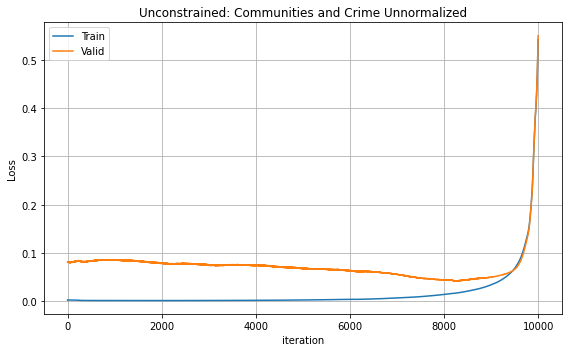

In [149]:
# Plot unconstrained loss function vs iterations
train_loss = pd.read_csv('data_lockdown_13LungCancer/lrs/train_loss05_5.csv')
valid_loss = pd.read_csv('data_lockdown_13LungCancer/lrs/valid_loss05_5.csv')

fig, axes = plt.subplots(figsize=(8,5))

axes.plot(train_loss["iteration"].tolist(), train_loss["loss"].tolist(), label="Train")
axes.plot(valid_loss["iteration"].tolist(), valid_loss["loss"].tolist(), label="Valid")
axes.legend()
axes.set_xlabel("iteration")
axes.set_ylabel("Loss")
axes.set_title("Unconstrained: Communities and Crime Unnormalized")
axes.grid(True, zorder=2)

plt.tight_layout()
# plt.savefig("data_unconstrained_friedman1_04/loss_vs_iter_forward.pdf", bbox_inches='tight')
plt.show()

* ### Comparison

In [2]:
# Read distributions
accuracy_lockdown = pd.read_csv('data_lockdown_13LungCancer/accuracy13_backward05.csv', index_col=0)
accuracy_forward  = pd.read_csv('data_unconstrained_13LungCancer/accuracy13_forward05.csv', index_col=0)
accuracy_xgb      = pd.read_csv('data_xgb_13LungCancer/accuracy13_xgb.csv')
accuracy_lasso    = pd.read_csv('data_lasso_13LungCancer/accuracy13_lasso_val.csv', index_col=0)

In [147]:
# Accuracy & Loss
print("Accuracy on 'test' set:")
print("Lockdown = {:.4f} +/- {:.3f}".format(accuracy_lockdown['test_acc'].mean(), 
                                            accuracy_lockdown['test_acc'].std()))
print("Forward  = {:.4f} +/- {:.3f}".format(accuracy_forward['test_acc'].mean(), 
                                            accuracy_forward['test_acc'].std()))
print("xgboost  = {:.4f} +/- {:.3f}".format(accuracy_xgb['test_acc'].mean(), 
                                            accuracy_xgb['test_acc'].std()))
print("Lasso    = {:.4f} +/- {:.3f}".format(accuracy_lasso['test_acc'].mean(), 
                                            accuracy_lasso['test_acc'].std()))

print("\nAccuracy on 'validation' set:")
print("Lockdown = {:.4f} +/- {:.3f}".format(accuracy_lockdown['valid_acc'].mean(), 
                                            accuracy_lockdown['valid_acc'].std()))
print("Forward  = {:.4f} +/- {:.3f}".format(accuracy_forward['valid_acc'].mean(), 
                                            accuracy_forward['valid_acc'].std()))
print("xgboost  = {:.4f} +/- {:.3f}".format(accuracy_xgb['valid_acc'].mean(), 
                                            accuracy_xgb['valid_acc'].std()))
print("Lasso    = {:.4f} +/- {:.3f}".format(accuracy_lasso['valid_acc'].mean(), 
                                            accuracy_lasso['valid_acc'].std()))

Accuracy on 'test' set:
Lockdown = 0.9810 +/- 0.004
Forward  = 0.9763 +/- 0.005
xgboost  = 0.9814 +/- 0.005
Lasso    = 0.9798 +/- 0.005

Accuracy on 'validation' set:
Lockdown = 0.9816 +/- 0.005
Forward  = 0.9758 +/- 0.006
xgboost  = 0.9809 +/- 0.006
Lasso    = 0.9794 +/- 0.005


In [148]:
# Print out test results
print("On 'test' set:")
statistic, pvalue = stats.ttest_rel(accuracy_lockdown['test_acc'], accuracy_forward['test_acc'])
print("Lockdown vs Forward: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown['test_acc'], accuracy_xgb['test_acc'])
print("Lockdown vs xgboost: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown['test_acc'], accuracy_lasso['test_acc'])
print("Lockdown vs lasso:   pvalue={:e}, statistic={:e}".format(pvalue, statistic))

# 
print("\nOn 'validation' set:")
statistic, pvalue = stats.ttest_rel(accuracy_lockdown['valid_acc'], accuracy_forward['valid_acc'])
print("Lockdown vs Forward: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown['valid_acc'], accuracy_xgb['valid_acc'])
print("Lockdown vs xgboost: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown['valid_acc'], accuracy_lasso['valid_acc'])
print("Lockdown vs lasso:   pvalue={:e}, statistic={:e}".format(pvalue, statistic))

On 'test' set:
Lockdown vs Forward: pvalue=6.481277e-22, statistic=1.242189e+01
Lockdown vs xgboost: pvalue=3.197485e-01, statistic=-1.000000e+00
Lockdown vs lasso:   pvalue=3.662937e-04, statistic=3.690418e+00

On 'validation' set:
Lockdown vs Forward: pvalue=6.200489e-23, statistic=1.290451e+01
Lockdown vs xgboost: pvalue=1.028423e-01, statistic=1.646449e+00
Lockdown vs lasso:   pvalue=5.890593e-08, statistic=5.867357e+00


In [3]:
# Relative Root Mean Squared Error
rrmse_lasso = 1.0 - accuracy_lasso['test_acc']
print("Lasso   = {:.3f} +/- {:.3f}".format(rrmse_lasso.mean(), rrmse_lasso.std()))

rrmse_GB = 1.0 - accuracy_xgb['test_acc']
print("GB      = {:.3f} +/- {:.3f}".format(rrmse_GB.mean(), rrmse_GB.std()))

rrmse_fcnn = 1.0 - accuracy_forward['test_acc']
print("FCNN    = {:.3f} +/- {:.3f}".format(rrmse_fcnn.mean(), rrmse_fcnn.std()))

rrmse_lockout = 1.0 - accuracy_lockdown['test_acc']
print("Lockout = {:.3f} +/- {:.3f}".format(rrmse_lockout.mean(), rrmse_lockout.std()))

# Print out test results
print("\nOn 'test' set:")
statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_fcnn)
print("Lockdown vs Forward: pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_GB)
print("Lockdown vs xgboost: pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_lasso)
print("Lockdown vs lasso:   pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

Lasso   = 0.020 +/- 0.005
GB      = 0.019 +/- 0.005
FCNN    = 0.024 +/- 0.005
Lockout = 0.019 +/- 0.004

On 'test' set:
Lockdown vs Forward: pvalue=6.48e-22, statistic=-1.24e+01
Lockdown vs xgboost: pvalue=3.20e-01, statistic=1.00e+00
Lockdown vs lasso:   pvalue=3.66e-04, statistic=-3.69e+00
